<b>Цели проекта постоить две модели, которые смогут:<br></b>
    1. Предсказать уровень удовлетворённости сотрудника на основе данных заказчика;<br>
    2. На основе данных заказчика предсказать то, что сотрудник уволится из компании.

<b>Входные данные<br></b>
Компания предоставила данные с характеристиками сотрудников компании. 
Среди них — уровень удовлетворённости сотрудника работой в компании. 
Эту информацию получили из форм обратной связи: 
    сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости
    от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.<br>


Для выполнения первой цели получена информация с данными для работы находятся в нескольких таблицах:<br>
    1. Таблица «train_job_satisfaction_rate.csv» содержит данные о тренировочная выборке.<br>
    2. Таблица «test_features.csv» содержит данные о входных признаках тестовой выборки.<br>
    3. Таблица «test_target_job_satisfaction_rate.csv» содержит данные о целевом признаке тестовой выборки.<br>
    
Для выполнения второй цели получена информация с данными для работы находятся в нескольких таблицах:<br>
    1. Таблица «train_quit.csv» содержит данные о тренировочная выборке.<br>
    2. Таблица «test_features.csv» содержит данные о входных признаках тестовой выборки.<br>
    3. Таблица «test_target_quit.csv» содержит данные о целевом признаке тестовой выборки.<br>

In [1]:
# установка библиотек
!pip install phik -q
!pip install shap -q 
!pip install -U scikit-learn -q

In [2]:
# импорт библиотек
import os 
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import sklearn
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import shap
import copy

# загружаем класс для разбиения данных
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler,
    LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification


# загружаем модели
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor


# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, make_scorer

In [4]:
# константы 
RANDOM_STATE = 42

In [5]:
scaler = StandardScaler()
encoder = OneHotEncoder()
clf = LogisticRegression(random_state=RANDOM_STATE,solver='liblinear',penalty='l1')
model_lr  = LinearRegression()

## Задача №1.

### Загрузка данных.

In [6]:
# Файлы train_job_satisfaction_rate.csv, test_features.csv, test_target_job_satisfaction_rate.csv 
# Загрузка данных из таблиц в переменные используя разделитель ","

pth1 = '/datasets/train_job_satisfaction_rate.csv'
pth2 = '/datasets/test_features.csv'
pth3 = '/datasets/test_target_job_satisfaction_rate.csv'

if os.path.exists(pth1):
    train_job_satisfaction_rate = pd.read_csv(pth1,delimiter=',',parse_dates=True)
    print(f'Файл train_job_satisfaction_rate.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')
    
if os.path.exists(pth2):
    test_features = pd.read_csv(pth2,delimiter=',',parse_dates=True)
    print(f'Файл test_features.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')
    
if os.path.exists(pth3):
    test_target_job_satisfaction_rate = pd.read_csv(pth3,delimiter=',')
    print(f'Файл test_target_job_satisfaction_rate.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')
    

Файл train_job_satisfaction_rate.csv успешно загружен
Файл test_features.csv успешно загружен
Файл test_target_job_satisfaction_rate.csv успешно загружен


#### Проверим, что данные в таблицах соответствуют описанию.

In [7]:
train_job_satisfaction_rate.info()
test_features.info()
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----

#### Вывод первого шага.

Таблицы загружены без ошибок, данные в таблицах предаствленны. Можно продолжать работу с ними. На этом этапе уже видны проуски в таблиццах. Уберем их позже в проекте.

### Предобработка данных.

#### Таблица train_job_satisfaction_rate. Проведем необходимую предобработку данных.

In [8]:
# рассмотрим таблицу train_job_satisfaction_rate
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [9]:
# рассмотрим записи в таблице train_job_satisfaction_rate
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


В таблице есть некорретно указаное написание столбцов и типы данных.

In [10]:
# проверим неявные дубликаты в колонках 
for i in train_job_satisfaction_rate.iloc[:, 0:len(train_job_satisfaction_rate)]:
    print(train_job_satisfaction_rate[i].value_counts(),'\n')

296961    1
898488    1
783768    1
910746    1
613789    1
         ..
463527    1
862888    1
548638    1
624165    1
428031    1
Name: id, Length: 4000, dtype: int64 

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64 

junior    1894
middle    1744
sinior     358
Name: level, dtype: int64 

medium    2066
low       1200
high       734
Name: workload, dtype: int64 

1     966
2     785
3     483
4     384
5     380
7     301
6     287
8     193
9     130
10     91
Name: employment_years, dtype: int64 

no     3880
yes     120
Name: last_year_promo, dtype: int64 

no     3441
yes     559
Name: last_year_violations, dtype: int64 

4    1603
3    1263
5     546
2     387
1     201
Name: supervisor_evaluation, dtype: int64 

24000    187
27600    184
26400    167
21600    167
28800    164
        ... 
85200      1
91200      1
97200      1
74400      1
98400      1
Name: salary, Length: 68, dtype: int64 

0.65    94
0

Неявных дубликатов в таблице не найдено. Значение "sinior" написано некорретно, но изменять его не будем, вдруг, так принято в компании.

In [11]:
# выполним проверку полных дубликатов
train_job_satisfaction_rate[train_job_satisfaction_rate.duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


Полных дубликатов также не найдено в таблице.

In [12]:
# узнаем количество пропусков
train_job_satisfaction_rate.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Пропуски имеют в двух столбцах. По условиям задания они будут заполнены в пайплайне.

#### Таблица test_features. Проведем необходимую предобработку данных. 

In [13]:
# рассмотрим таблицу test_features
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [14]:
# рассмотрим записи в таблице test_features
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [15]:
# проверим неявные дубликаты в колонках 
for i in test_features.iloc[:, 0:len(test_features)]:
    print(test_features[i].value_counts(),'\n')

727043    1
340625    1
996005    1
356579    1
791203    1
         ..
683546    1
867647    1
314685    1
527675    1
200700    1
Name: id, Length: 2000, dtype: int64 

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64 

junior    974
middle    854
sinior    171
Name: level, dtype: int64 

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64 

1     522
2     374
3     234
4     187
5     179
7     174
6     138
8      91
9      66
10     35
Name: employment_years, dtype: int64 

no     1937
yes      63
Name: last_year_promo, dtype: int64 

no     1738
yes     262
Name: last_year_violations, dtype: int64 

4    857
3    575
5    284
2    196
1     88
Name: supervisor_evaluation, dtype: int64 

27600    109
26400     95
24000     93
19200     83
21600     83
        ... 
88800      2
80400      2
96000      1
75600      1
92400      1
Name: salary, Length: 66, dtype: 

Неявных дубликатов в таблице не найдено. Значение "sinior" оставим без измненений.

In [16]:
# выполним проверку полных дубликатов
test_features[test_features.duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary


Полных дубликатов также не найдено в таблице.

In [17]:
# узнаем количество пропусков
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Пропуски имеют в двух столбцах. По условиям задания они будут заполнены в пайплайне.

#### Таблица test_target_job_satisfaction_rate. Проведем необходимую предобработку данных.

In [18]:
# рассмотрим таблицу test_features
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [19]:
# рассмотрим записи в таблице test_features
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Таблица без пропусков и содержит целевой признак тестовой выборки.

#### Вывод воторого шага.

Таблицы проверены и дубликаты не найденые. Устранения дубликатов будет проводиться в рамках подготовки пайплайна.

### Шаг. Исследовательский анализ данных.

#### Таблица train_job_satisfaction_rate. Исследовательский анализ данных.

In [20]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


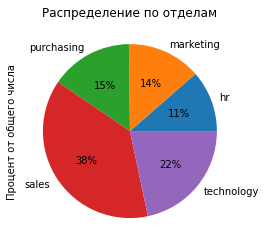

In [21]:
labels = train_job_satisfaction_rate.pivot_table(index='dept', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_job_satisfaction_rate.pivot_table(
        index='dept', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по отделам'
)

plt.show()

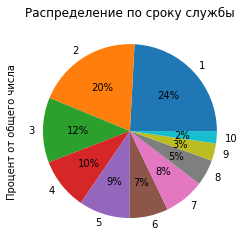

In [22]:
labels = train_job_satisfaction_rate.pivot_table(index='employment_years', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_job_satisfaction_rate.pivot_table(
        index='employment_years', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по сроку службы'
)

plt.show()

Большую часть составляют сотрудники от 1-2 лет работы: 44%. Затем от 3-4 лет работы: 22%.

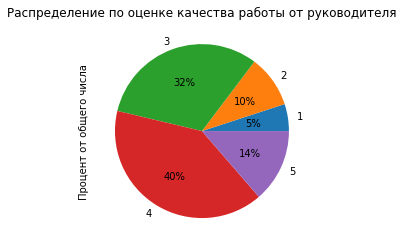

In [23]:
labels = train_job_satisfaction_rate.pivot_table(index='supervisor_evaluation', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_job_satisfaction_rate.pivot_table(
        index='supervisor_evaluation', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по оценке качества работы от руководителя'
)

plt.show()

40% сотрудников имеют оценку 4. 32% сотрудкников имеют оценку 3. Немного не хватило до 15% сотрудникам отличникам, у них 14%. Единиццу послучили 5% сотрудников.

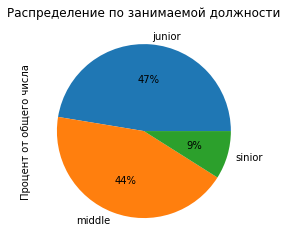

In [25]:
labels = train_job_satisfaction_rate.pivot_table(index='level', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_job_satisfaction_rate.pivot_table(
        index='level', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по занимаемой должности'
)

plt.show()

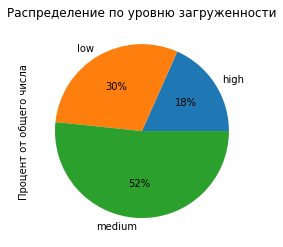

In [26]:
labels = train_job_satisfaction_rate.pivot_table(index='workload', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_job_satisfaction_rate.pivot_table(
        index='workload', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по уровню загруженности'
)

plt.show()

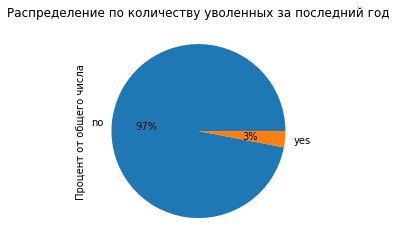

In [27]:
labels = train_job_satisfaction_rate.pivot_table(
    index='last_year_promo', 
    values='id', 
    aggfunc='count'
).index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_job_satisfaction_rate.pivot_table(
        index='last_year_promo', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по количеству уволенных за последний год'
)

plt.show()

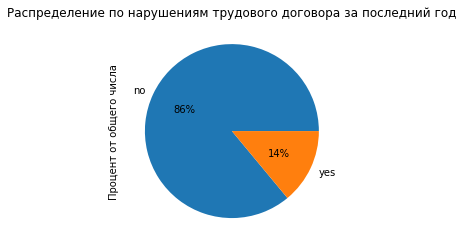

In [28]:
labels = train_job_satisfaction_rate.pivot_table(
    index='last_year_violations', 
    values='id', 
    aggfunc='count'
).index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_job_satisfaction_rate.pivot_table(
        index='last_year_violations', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по нарушениям трудового договора за последний год'
)

plt.show()

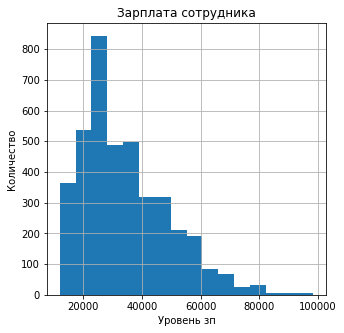

In [29]:
# построим распределение
train_job_satisfaction_rate['salary'].hist(bins=16,figsize=(5,5))
plt.title('Зарплата сотрудника')
plt.xlabel('Уровень зп')
plt.ylabel('Количество')
plt.show()

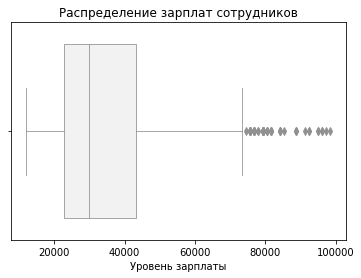

In [30]:
# график распределения
sns.boxplot(
    x=train_job_satisfaction_rate['salary'],
    color='0.95', 
    linewidth=0.8
)
plt.title('Распределение зарплат сотрудников')
plt.xlabel('Уровень зарплаты')
plt.ylabel('')
plt.show()

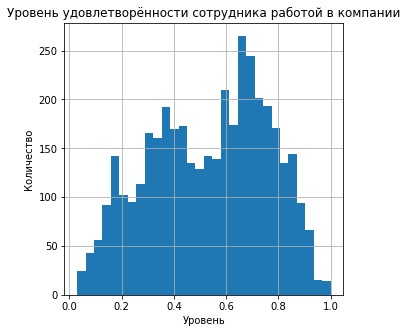

In [31]:
# построим распределение
train_job_satisfaction_rate['job_satisfaction_rate'].hist(bins=30,figsize=(5,5))
plt.title('Уровень удовлетворённости сотрудника работой в компании')
plt.xlabel('Уровень')
plt.ylabel('Количество')
plt.show()

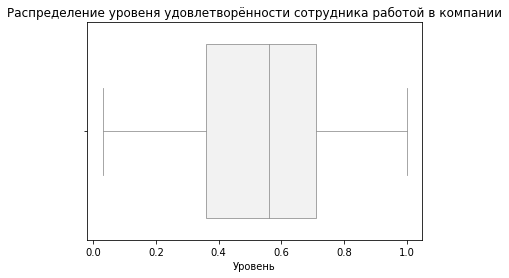

In [32]:
# график распределения внутри годов 
sns.boxplot(
    x=train_job_satisfaction_rate['job_satisfaction_rate'],
    color='0.95', 
    linewidth=0.8
)
plt.title('Распределение уровеня удовлетворённости сотрудника работой в компании')
plt.xlabel('Уровень')
plt.ylabel('')
plt.show()

#### Таблица test_features. Исследовательский анализ данных.

In [33]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


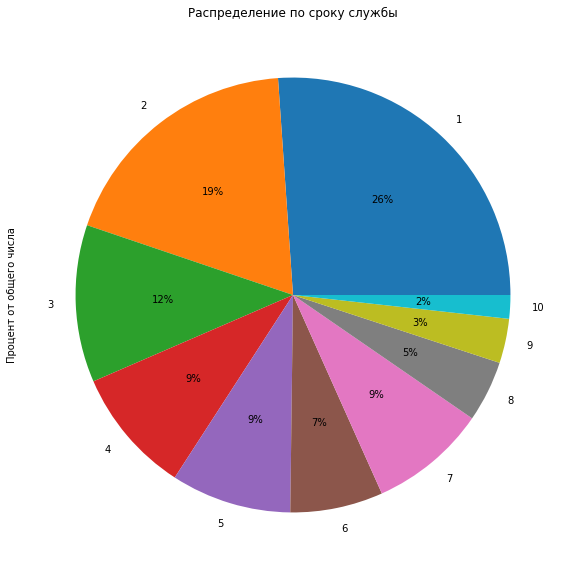

In [49]:
labels = test_features.pivot_table(index='employment_years', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots(figsize=(10, 10))

ax.pie(
    test_features.pivot_table(
        index='employment_years', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по сроку службы'
)

plt.show()

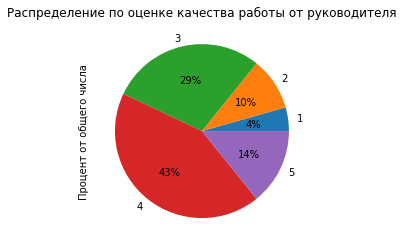

In [43]:
labels = test_features.pivot_table(index='supervisor_evaluation', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()
ax.pie(
    test_features.pivot_table(
        index='supervisor_evaluation', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по оценке качества работы от руководителя'
)
plt.show()

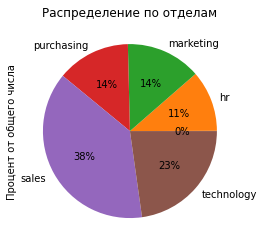

In [51]:
labels = test_features.pivot_table(
    index='dept', 
    values='id', 
    aggfunc='count'
).index.unique()
fig, ax = plt.subplots()

ax.pie(
    test_features.pivot_table(
        index='dept', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по отделам'
)

plt.show()

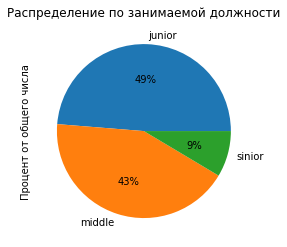

In [35]:
labels = test_features.pivot_table(index='level', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    test_features.pivot_table(
        index='level', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по занимаемой должности'
)

plt.show()

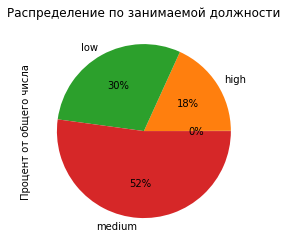

In [36]:
labels = test_features.pivot_table(index='workload', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    test_features.pivot_table(
        index='workload', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по занимаемой должности'
)

plt.show()

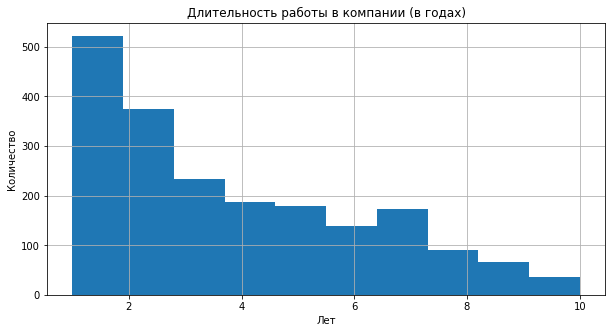

In [37]:
# построим распределение
test_features['employment_years'].hist(bins=10,figsize=(10,5))
plt.title('Длительность работы в компании (в годах)')
plt.xlabel('Лет')
plt.ylabel('Количество')
plt.show()

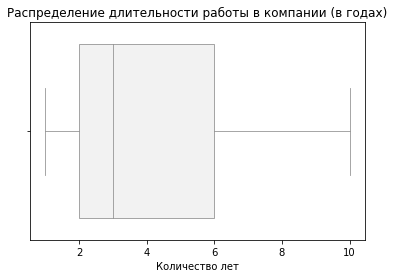

In [38]:
# график распределения внутри годов 
sns.boxplot(
    x=train_job_satisfaction_rate['employment_years'],
    color='0.95', 
    linewidth=0.8
)
plt.title('Распределение длительности работы в компании (в годах)')
plt.xlabel('Количество лет')
plt.ylabel('')
plt.show()

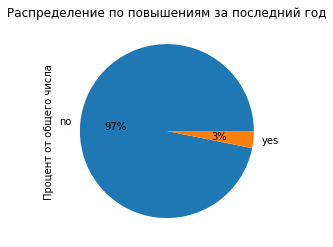

In [40]:
labels = test_features.pivot_table(index='last_year_promo', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    test_features.pivot_table(
        index='last_year_promo', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по повышениям за последний год'
)

plt.show()

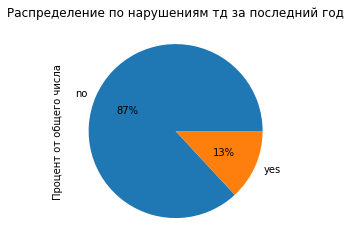

In [41]:
labels = test_features.pivot_table(index='last_year_violations', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    test_features.pivot_table(
        index='last_year_violations', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по нарушениям тд за последний год'
)

plt.show()

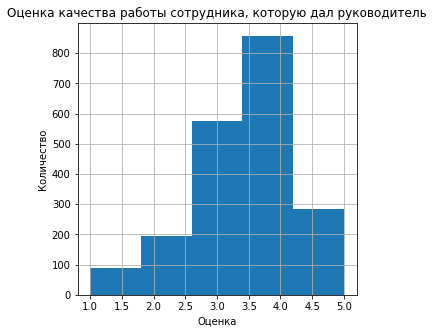

In [41]:
# построим распределение
test_features['supervisor_evaluation'].hist(bins=5,figsize=(5,5))
plt.title('Оценка качества работы сотрудника, которую дал руководитель')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show()

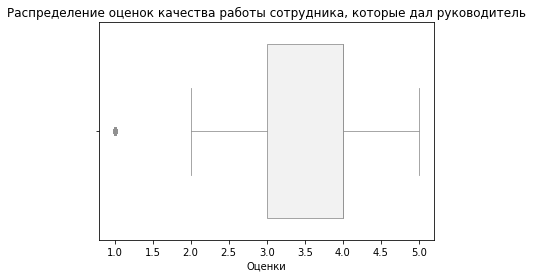

In [42]:
# график распределения внутри годов 
sns.boxplot(
    x=test_features['supervisor_evaluation'],
    color='0.95', 
    linewidth=0.8
)
plt.title('Распределение оценок качества работы сотрудника, которые дал руководитель')
plt.xlabel('Оценки')
plt.ylabel('')
plt.show()

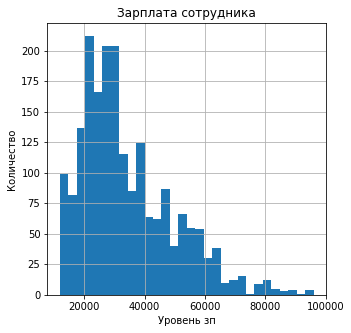

In [43]:
# построим распределение
test_features['salary'].hist(bins=30,figsize=(5,5))
plt.title('Зарплата сотрудника')
plt.xlabel('Уровень зп')
plt.ylabel('Количество')
plt.show()

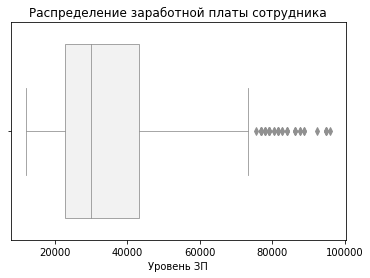

In [44]:
# график распределения внутри годов 
sns.boxplot(
    x=test_features['salary'],
    color='0.95', 
    linewidth=0.8
)
plt.title('Распределение заработной платы сотрудника')
plt.xlabel('Уровень ЗП')
plt.ylabel('')
plt.show()

#### Вывод EDA шага.

Тренировочные и тестовые данные распределены относительно равномерно. По отделам внутри компании преобладает отдел продаж, по уровню занимаемой должности - junior и middle имеют больший вес, по загруженности больше всего сотрудников со средним уровнем загруженности. За последний год повышение было только у 3% сотрудников, а нарушения трудового договора выявлены у 14% сотрудников. В ежемесячной зарплате сотрудников имеется сдвиг влево, а в уровне удовлетворенности сотрудников - сдвиг вправо. В зарплате и оценке руководителя наблюдаются выбросы, но они в допустимых значениях. 

#### Вычисление матрицы корреляции.

In [26]:
dt = train_job_satisfaction_rate.iloc[:,1:]

In [27]:
dt.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,junior,medium,2,no,no,1,24000,0.58
1,hr,junior,high,2,no,no,5,38400,0.76
2,sales,junior,low,1,no,no,2,12000,0.11
3,technology,junior,low,4,no,no,2,18000,0.37
4,hr,junior,medium,1,no,no,3,22800,0.20


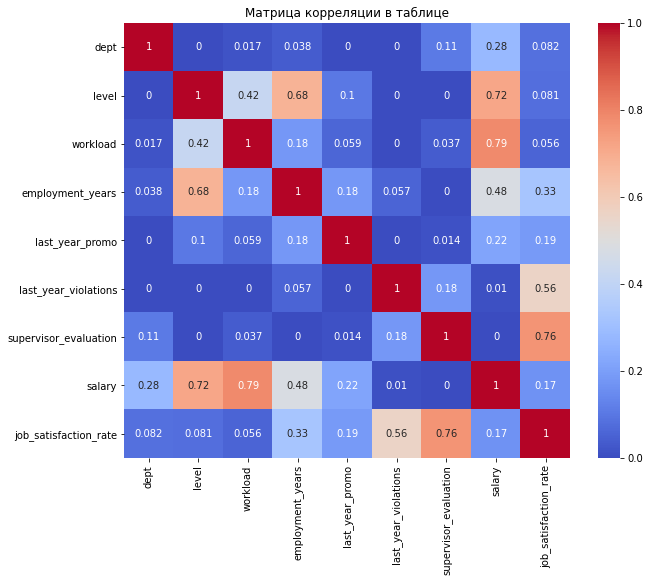

In [29]:
# вычисление матрицы корреляции с использованием phik
plt.figure(figsize=(10, 8))
sns.heatmap(
    dt.phik_matrix(
        interval_cols=[
            'salary',
            'job_satisfaction_rate'
        ]
    ),
    annot=True,
    cmap='coolwarm'
)
plt.title('Матрица корреляции в таблице')
plt.show()

#### Вывод вычисления корреляции.

Очень высоких корреляций (0.9 +) не видно, скорее всего, мультиколлинеарности нет.<br>
Сильная корреляция наблюдается в связи с Уровенем загруженности сотрудника и Зарплатой (0,79), Уровень удовлетворённости сотрудника работой в компании и Оценка качества работы сотрудника, которую дал руководитель (0,76), и Уровень занимаемой должности и Зарплата (0,72).<br>
Остальные значения имеют низкую корреляцию. 

#### Вывод третьего шага.

По итогам анализа можно сказать, что данные выглядят достоверно, особых выбросов нет, при проведении корреляционного анализа утечки целевого признака не обнаружено. Перед обучением необходимо будет провести подготовку данных в пайплайне: масштабирование количественных признаков, кодирование категориальных признаков, обработку пропусков. Для подготовки данных будем использовать ColumnTransformer.

### Подготовка данных.

<i>Подготовку признаков выполните в пайплайне, дополнив пайплайн шага предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

In [30]:
# создаём списки с названиями признаков

ohe_columns = [
    'dept',
    'last_year_promo', 
    'last_year_violations'
]

ord_columns = [ 
    'level', 
    'workload'
]

num_columns = [
    'salary',
    'employment_years', 
    'supervisor_evaluation'
]

Так как по условию нам уже даны тестовые и тренировочные данные, то для X и y задаим эти значения.

In [33]:
X_test_1 = copy.copy(test_features)
y_test = copy.copy(test_target_job_satisfaction_rate)

In [36]:
X_train_1 = train_job_satisfaction_rate.drop(columns=['id'], axis=1)

In [37]:
X_train_1.duplicated().sum()

245

In [38]:
X_train_1 = X_train_1.drop_duplicates().reset_index(drop=True)

In [39]:
X_train_1.shape

(3755, 9)

In [40]:
y_train_1 = X_train_1['job_satisfaction_rate']

In [41]:
X_train_1 = X_train_1.iloc[:,:8]

In [42]:
# объеденим тестовые данные в одну таблицу
data_test = X_test_1.merge(y_test, on='id')

In [43]:
# выделим и уберем принак соотвественно из таблицы
X_test_1 = data_test.drop(['job_satisfaction_rate','id'], axis=1)
X_test_1.shape

(2000, 8)

In [44]:
y_test_1 = data_test['job_satisfaction_rate']

In [45]:
# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE + SimpleImputer
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior','middle','sinior'],
                    ['low','medium','high']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [46]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            
        ),
        (
            'ohe',
            OneHotEncoder(handle_unknown='ignore', drop='first')
        )
    ]
)

In [47]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ord_pipe,ord_columns),
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(),num_columns)
    ],
    remainder='passthrough'
)

In [48]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor',data_preprocessor),
        ('models', model_lr)
    ]
)

In [49]:
param_grid = [
    # словарь для модели Linear Regression()
    {
        'models': [model_lr],
        'models__fit_intercept': [True, False],
        'preprocessor__num': [MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [MinMaxScaler(), 'passthrough']  
    }
]

In [50]:
# подготавливаем диграмму пайплайна и выводим ее
sklearn.set_config(display='diagram')
pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('num', StandardScaler(),
                                                  ['salary', 'employment_years',
                                                   'supervisor_evaluation'])])),
                ('models', LinearRegression())])

In [51]:
# ознакомимся с параметрами модели
pipe_final.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'preprocessor', 'models', 'preprocessor__force_int_remainder_cols', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__ord', 'preprocessor__ohe', 'preprocessor__num', 'preprocessor__ord__memory', 'preprocessor__ord__steps', 'preprocessor__ord__transform_input', 'preprocessor__ord__verbose', 'preprocessor__ord__simpleImputer_before_ord', 'preprocessor__ord__ord', 'preprocessor__ord__simpleImputer_after_ord', 'preprocessor__ord__simpleImputer_before_ord__add_indicator', 'preprocessor__ord__simpleImputer_before_ord__copy', 'preprocessor__ord__simpleImputer_before_ord__fill_value', 'preprocessor__ord__simpleImputer_before_ord__keep_empty_features', 'preprocessor__ord__simpleImputer_before_ord__missing_values', 'preprocessor__ord__simpleImputer_before

#### Вывод четвертого шага.

Категори выделены. Пропуски обрабатываеются в собранном Pipeline. В Pipeline используются по модели DecisionTreeRegressor, Linear Regression.

### Обучение моделей.

<i>Обучить две модели. 
Возять одну линейную модель, а в качестве второй — дерево решений. 
Подбрать гиперпараметры как минимум для одной модели с помощью одного из известных инструментов.
Выберите лучшую модель и проверьте её качество. Выбор сделать на основе новой метрики — SMAPE.

#### Сбор метрики SMAPE.

In [52]:
# создаем функцию для подcчета значения метрики SMAPE
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# обозначаем переменную
smape_scorer = make_scorer(smape, greater_is_better=False)

#### Обучение моделей.

In [53]:
# обозначение параметров для обучения перебором
grid_search_LR = GridSearchCV(
    pipe_final,
    param_grid = param_grid,
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)

In [54]:
# обучение модели на тренировочных данных
grid_search_LR.fit(X_train_1, y_train_1)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord',
                                                                                          OrdinalEncoder(categories=[['junior',
                                                                                                                      'middle',
                                                                                                                      'sinior'],
                                                                                                                     ['low',
                                                                                                                      'medium',
                                                                                                                      'high']],
                                                                                                         handle_unknown='use_encoded_value',
                                                                                                         unknown_value=nan))...
             param_grid=[{'models': [LinearRegression()],
                          'models__fit_intercept': [True, False],
                          'preprocessor__num': [MinMaxScaler(), 'passthrough']},
                         {'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(2, 15),
                          'models__max_features': range(2, 15),
                          'preprocessor__num': [MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [55]:
print('Лучшая модель и её параметры:\n\n', grid_search_LR.best_estimator_)

print ('Метрика лучшей модели на кросс-валидации:', grid_search_LR.best_score_*-1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                 

Лучшей моделью получилась модель дерева решений с максимальной глубиной 13 и максимальным числом признаков, по которым ищется лучшее разбиение в дереве равно 19.

In [56]:
# используем лучшую модель для прогнозирования на тестовых данных
y_pred_test = grid_search_LR.best_estimator_.predict(X_test_1)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [57]:
# расчетаем метрику SMAPE для текстовых данных
smape_test = smape(y_test_1, y_pred_test)
print ("Метрика SMAPE равна:", smape_test)

Метрика SMAPE равна: 14.265565988813533


Метрика получилась равной 14.26, что немного лучше, чем на тренировочной выборке.

In [58]:
# посмотрим результаты других параметров модели
model_done = pd.DataFrame(grid_search_LR.cv_results_)
model_done.mean_test_score = model_done.mean_test_score * -1
model_done

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__fit_intercept,param_preprocessor__num,param_models__max_depth,param_models__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.071717,0.028239,0.026628,0.027442,LinearRegression(),True,MinMaxScaler(),NaN,NaN,"{'models': LinearRegression(), 'models__fit_in...",-25.205444,-24.956479,-26.082386,-25.083587,-23.700211,25.005621,0.763144,311
1,0.088643,0.001238,0.011520,0.000229,LinearRegression(),True,passthrough,NaN,NaN,"{'models': LinearRegression(), 'models__fit_in...",-25.205444,-24.956479,-26.082386,-25.083587,-23.700211,25.005621,0.763144,310
2,0.080002,0.026593,0.025471,0.026253,LinearRegression(),False,MinMaxScaler(),NaN,NaN,"{'models': LinearRegression(), 'models__fit_in...",-28.302893,-28.242179,-29.284483,-27.693415,-26.688909,28.042376,0.849031,322
3,0.036661,0.027810,0.051454,0.032401,LinearRegression(),False,passthrough,NaN,NaN,"{'models': LinearRegression(), 'models__fit_in...",-24.857217,-24.311822,-25.161359,-24.764277,-23.541379,24.527211,0.563117,307
4,0.051387,0.031269,0.012552,0.000373,DecisionTreeRegressor(random_state=42),NaN,MinMaxScaler(),2.0,2.0,{'models': DecisionTreeRegressor(random_state=...,-28.300512,-27.469718,-29.671758,-28.168814,-26.643053,28.050771,1.002317,323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,0.026729,0.000490,0.011115,0.000598,DecisionTreeRegressor(random_state=42),NaN,passthrough,14.0,12.0,{'models': DecisionTreeRegressor(random_state=...,-15.315716,-15.036871,-16.766304,-16.546589,-15.817379,15.896572,0.672563,29
338,0.032276,0.004268,0.013480,0.001073,DecisionTreeRegressor(random_state=42),NaN,MinMaxScaler(),14.0,13.0,{'models': DecisionTreeRegressor(random_state=...,-15.318752,-15.139371,-16.815830,-16.513684,-15.612781,15.880084,0.665172,24
339,0.026891,0.000517,0.010665,0.000217,DecisionTreeRegressor(random_state=42),NaN,passthrough,14.0,13.0,{'models': DecisionTreeRegressor(random_state=...,-15.315716,-15.036871,-16.766304,-16.546589,-15.817379,15.896572,0.672563,29
340,0.030814,0.001531,0.013418,0.001857,DecisionTreeRegressor(random_state=42),NaN,MinMaxScaler(),14.0,14.0,{'models': DecisionTreeRegressor(random_state=...,-15.318752,-15.139371,-16.815830,-16.513684,-15.612781,15.880084,0.665172,24


Результаты линейной регрессии хуже, чем у дерева решений.

### Оформление выводов.

Была собрана модель для предсказания уровня удовлетворенности сотрудников на основе данных клиента.

Протестировано несколько моделей. Лучшей оказалась модель дерева решений с максимальной глубиной 14 и максимальным числом признаков для поиска наилучшего разбиения равным 13. Проверка на тестовой выборке показала, что значение метрики осталось примерно на том же уровне, что свидетельствует о хорошей работе модели.
Вероятно, дерево решений справилось лучше линейной регрессии из-за большей гибкости в настройке гиперпараметров.

## Задача №2.

### Загрузка данных.

In [52]:
# Файлы train_quit.csv, test_features.csv, test_target_quit.csv
# Загрузка данных из таблиц в переменные используя разделитель ","

pth1 = '/datasets/train_quit.csv'
pth2 = '/datasets/test_features.csv'
pth3 = '/datasets/test_target_quit.csv'

if os.path.exists(pth1):
    train_quit = pd.read_csv(pth1,delimiter=',',parse_dates=True)
    print(f'Файл train_quit.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')
    
if os.path.exists(pth2):
    test_features = pd.read_csv(pth2,delimiter=',',parse_dates=True)
    print(f'Файл test_features.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')
    
if os.path.exists(pth3):
    test_target_quit = pd.read_csv(pth3,delimiter=',')
    print(f'Файл test_target_quit.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')
    

Файл train_quit.csv успешно загружен
Файл test_features.csv успешно загружен
Файл test_target_quit.csv успешно загружен


In [53]:
# посмотрим общую информацию
train_quit.info()
test_features.info()
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id              

#### Вывод первого шага.

Таблицы успехно загруженны. В тренировочной выборке всё так же 4000 строк, в тестовой 2000. А таблица параметров остается прежней. Можно переходить к обработке.

### Предобработка данных.

In [54]:
# рассмотрим записи в таблице train_quit
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [55]:
# проверим неявные дубликаты в колонках 
for i in train_quit.iloc[:, 0:len(train_quit)]:
    print(train_quit[i].value_counts(),'\n')

737280    1
472476    1
992642    1
307213    1
540037    1
         ..
147931    1
676623    1
318226    1
963347    1
960511    1
Name: id, Length: 4000, dtype: int64 

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64 

junior    1949
middle    1694
sinior     357
Name: level, dtype: int64 

medium    2118
low       1208
high       674
Name: workload, dtype: int64 

1     985
2     777
3     479
4     393
5     362
7     308
6     296
8     174
9     136
10     90
Name: employment_years, dtype: int64 

no     3887
yes     113
Name: last_year_promo, dtype: int64 

no     3455
yes     545
Name: last_year_violations, dtype: int64 

4    1654
3    1233
5     520
2     391
1     202
Name: supervisor_evaluation, dtype: int64 

24000    200
27600    185
19200    182
26400    180
33600    164
        ... 
94800      2
85200      1
91200      1
86400      1
92400      1
Name: salary, Length: 69, dtype: int64 

no     2872


In [56]:
# выполним проверку полных дубликатов
train_quit[train_quit.duplicated()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit


In [57]:
# узнаем количество пропусков
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [58]:
# посмотрим таблицу ключевого признака test_target_quit
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [59]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


#### Вывод втогово шага.

В новых колонках quit в тренировочной и тестовой выборках ошибок не обнаружено.

### Исследовательский анализ данных.

#### Таблицца train_quit. Исследовательский анализ данных.

In [60]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


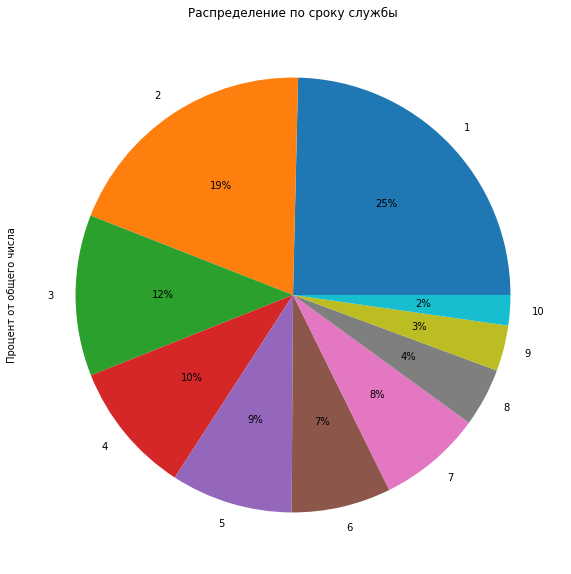

In [63]:
labels = train_quit.pivot_table(index='employment_years', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots(figsize=(10, 10))

ax.pie(
    train_quit.pivot_table(
        index='employment_years', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по сроку службы'
)

plt.show()

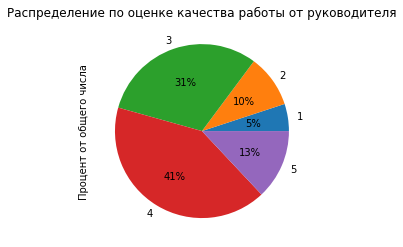

In [64]:
labels = train_quit.pivot_table(index='supervisor_evaluation', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()
ax.pie(
    train_quit.pivot_table(
        index='supervisor_evaluation', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по оценке качества работы от руководителя'
)
plt.show()

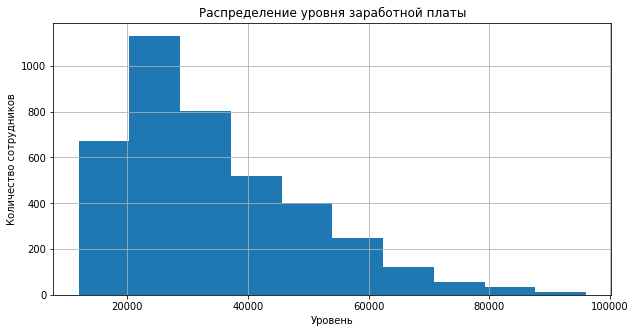

In [91]:
# построим распределение
train_quit['salary'].hist(bins=10,figsize=(10,5))
plt.title('Распределение уровня заработной платы')
plt.xlabel('Уровень')
plt.ylabel('Количество сотрудников')
plt.show()

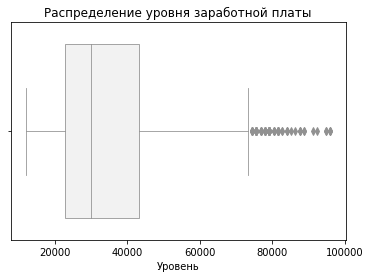

In [79]:
# график распределения зп 
sns.boxplot(
    x=train_quit['salary'],
    color='0.95', 
    linewidth=0.8
)
plt.title('Распределение уровня заработной платы')
plt.xlabel('Уровень')
plt.ylabel('')
plt.show()

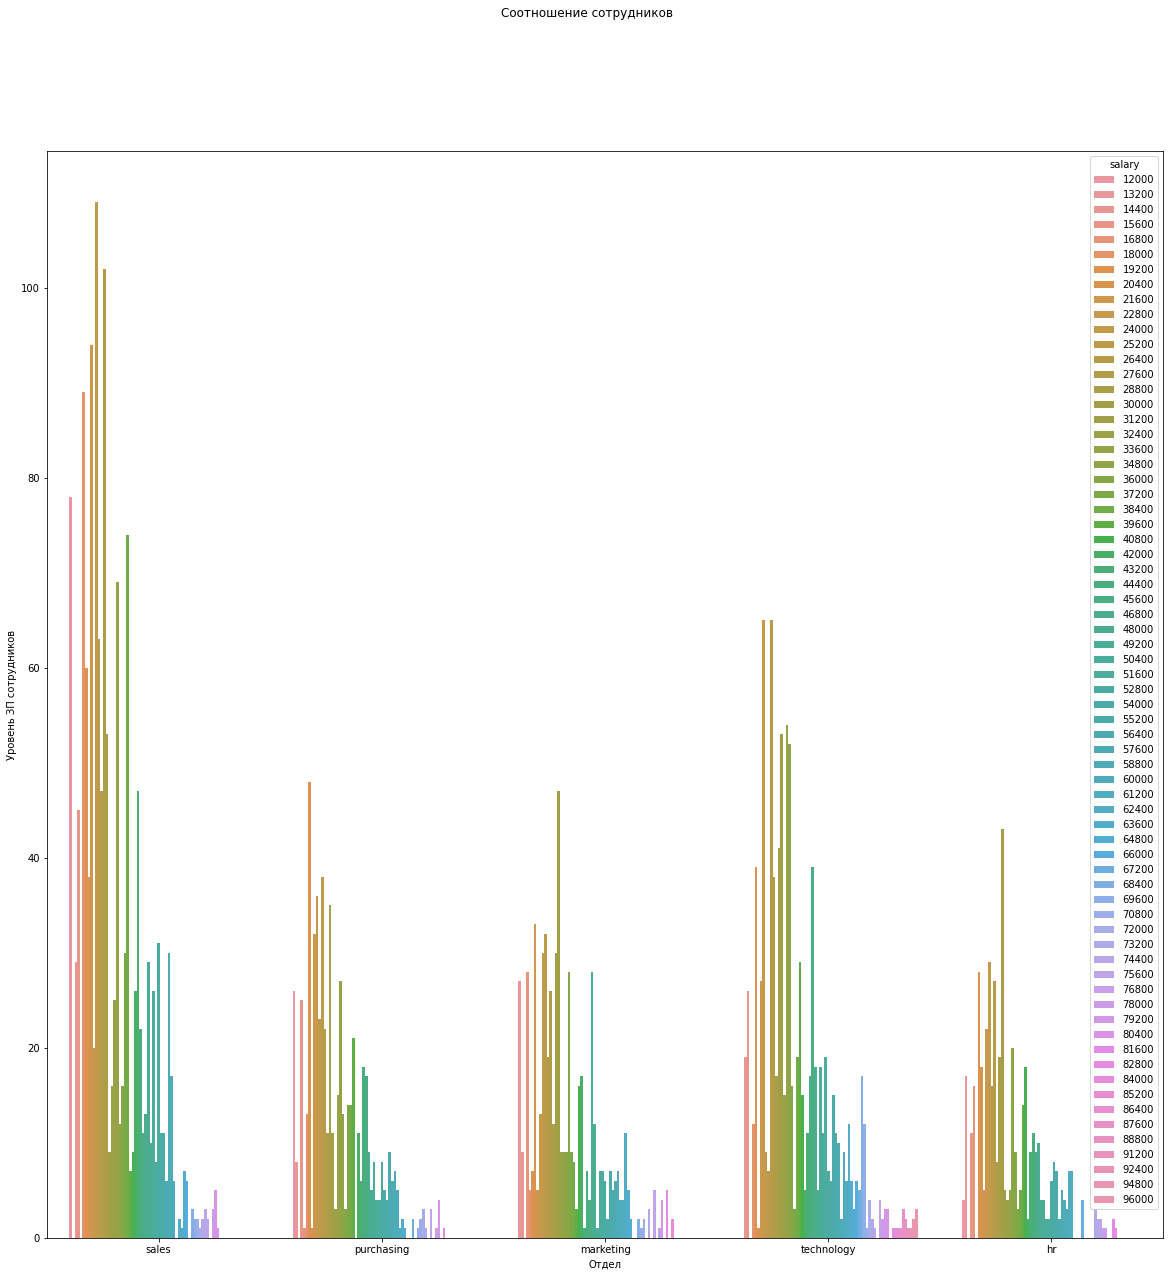

In [97]:
fig, axes = plt.subplots(figsize=(20,20))
plt.suptitle('Соотношение сотрудников')
sns.countplot(x='dept', data=train_quit, hue='salary').set(
    xlabel='Отдел', 
    ylabel='Уровень ЗП сотрудников'
)
plt.show()

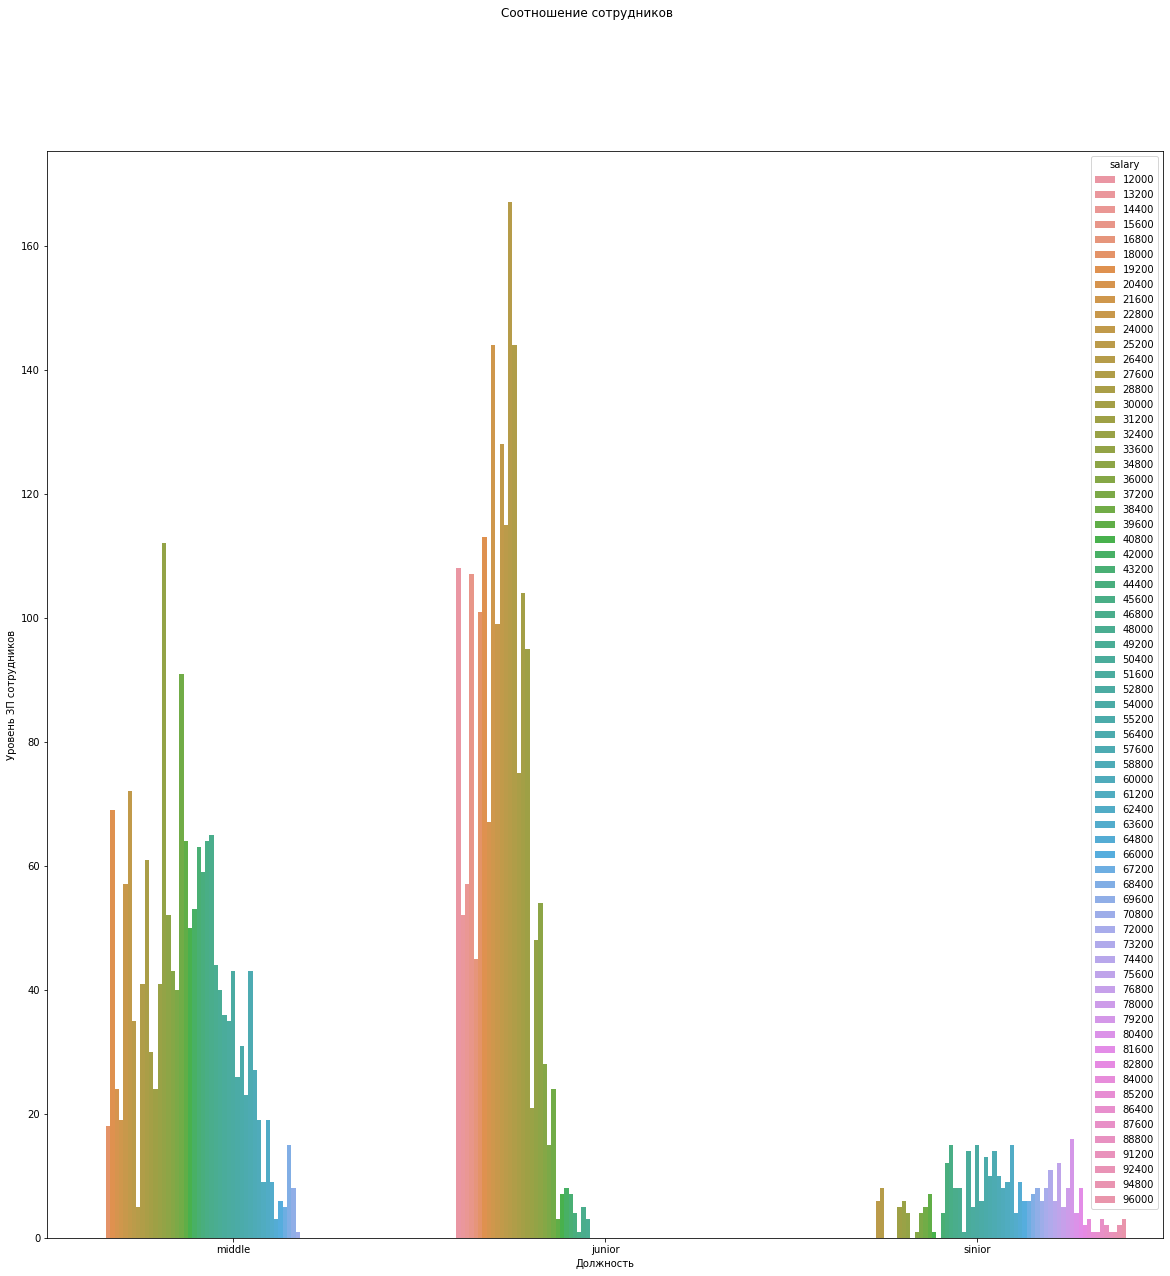

In [99]:
fig, axes = plt.subplots(figsize=(20,20))
plt.suptitle('Соотношение сотрудников')
sns.countplot(x='level', data=train_quit, hue='salary').set(
    xlabel='Должность', 
    ylabel='Уровень ЗП сотрудников'
)
plt.show()

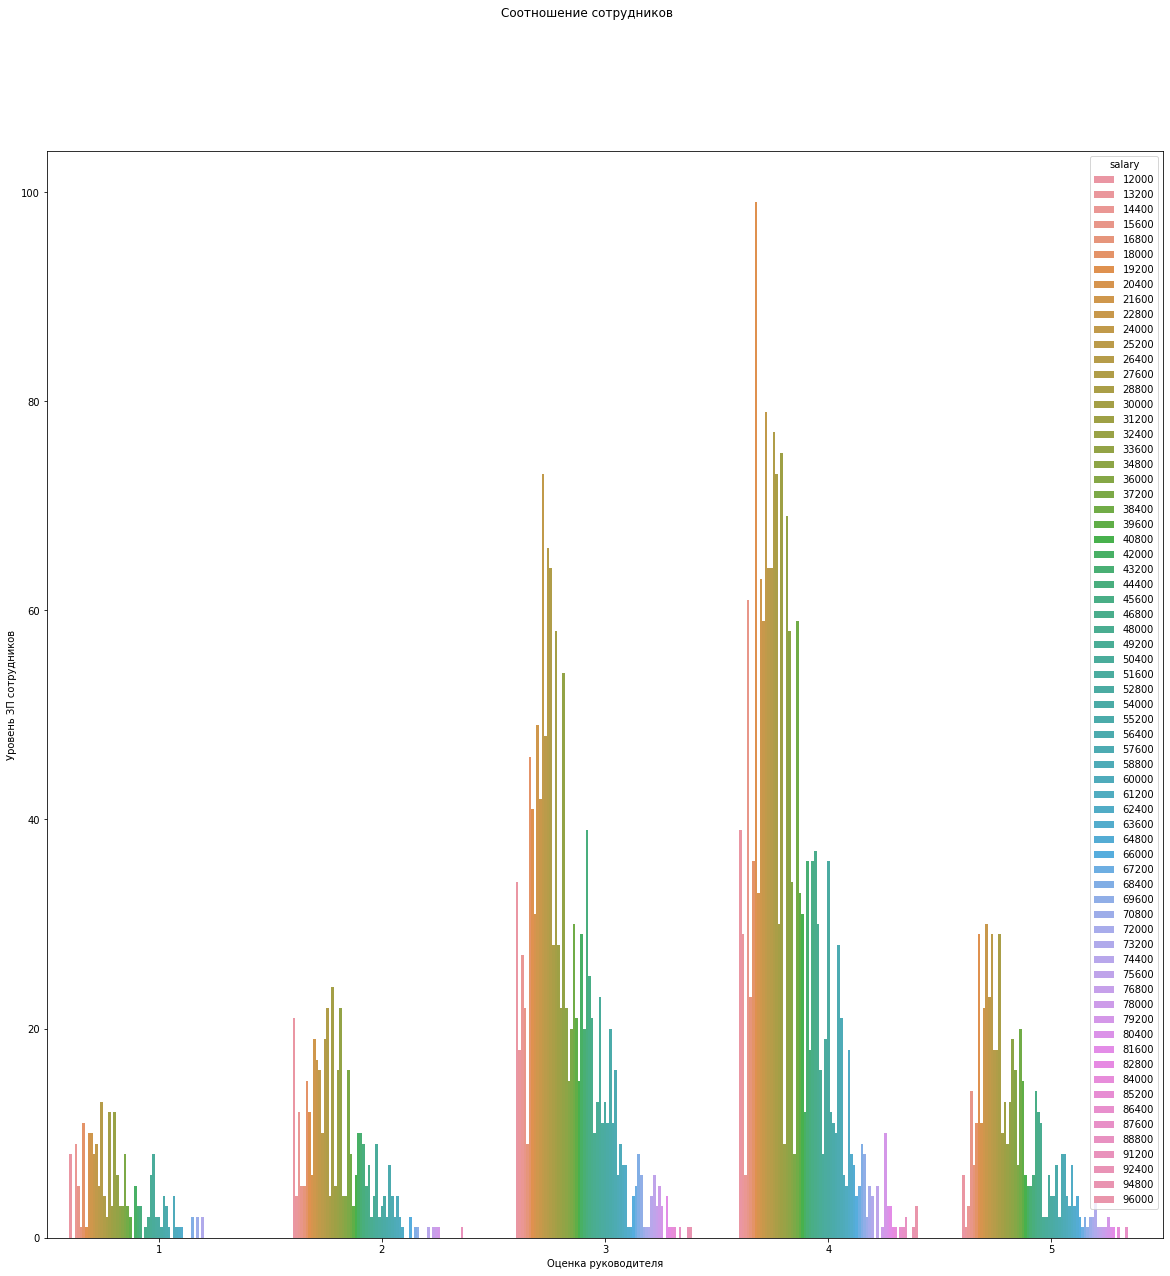

In [101]:
fig, axes = plt.subplots(figsize=(20,20))
plt.suptitle('Соотношение сотрудников')
sns.countplot(x='supervisor_evaluation', data=train_quit, hue='salary').set(
    xlabel='Оценка руководителя', 
    ylabel='Уровень ЗП сотрудников'
)
plt.show()

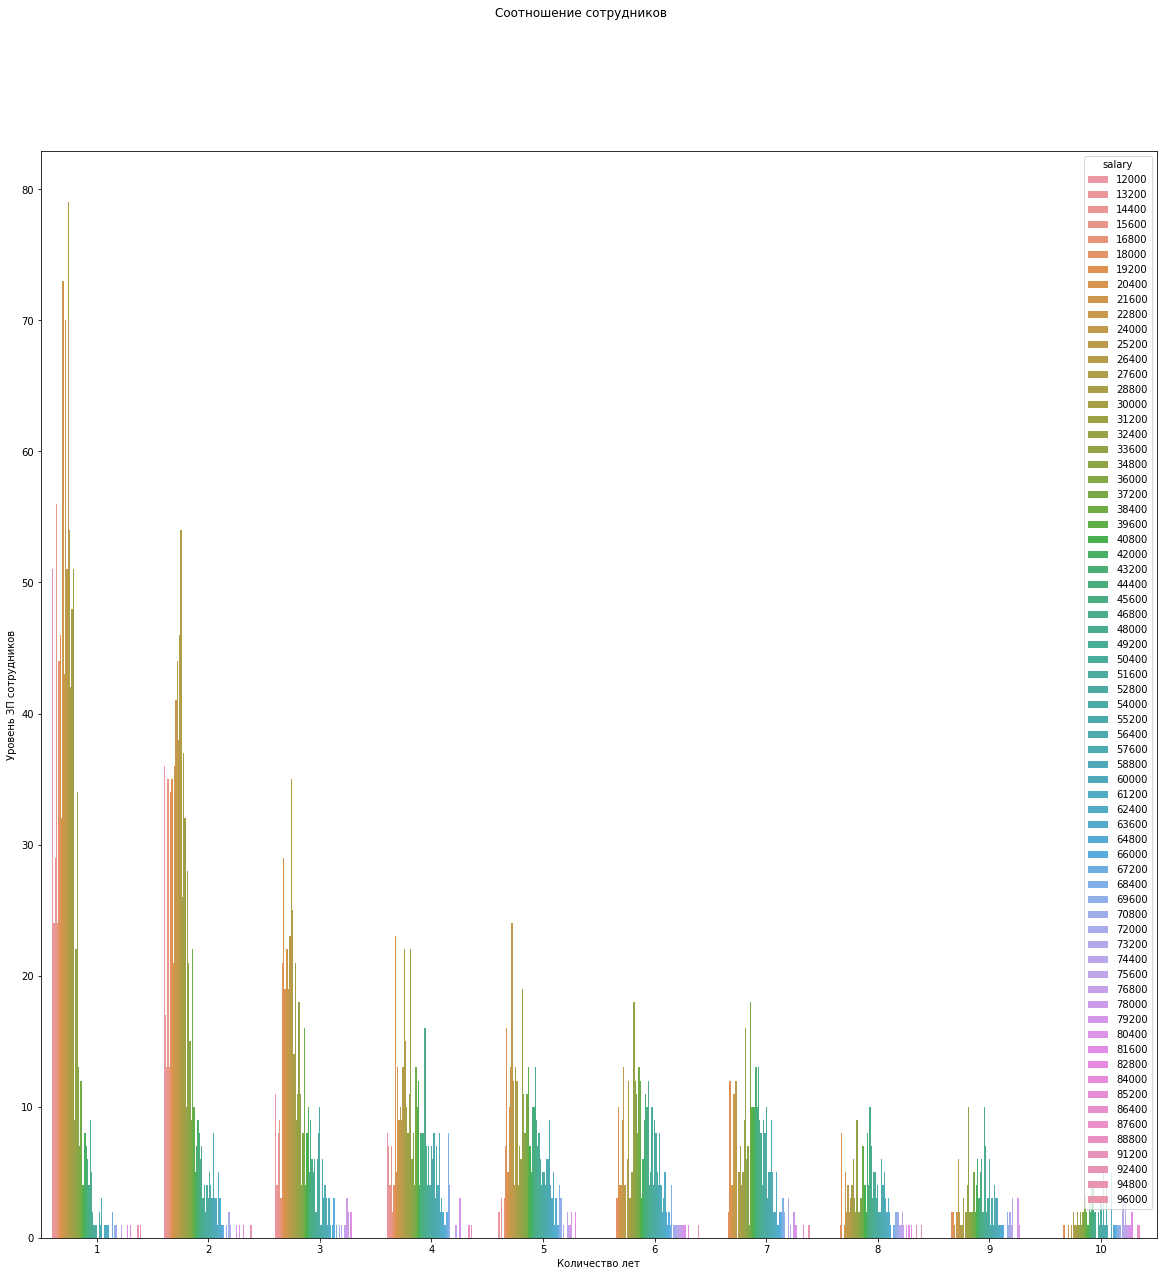

In [103]:
fig, axes = plt.subplots(figsize=(20,20))
plt.suptitle('Соотношение сотрудников')
sns.countplot(x='employment_years', data=train_quit, hue='salary').set(
    xlabel='Количество лет', 
    ylabel='Уровень ЗП сотрудников'
)
plt.show()

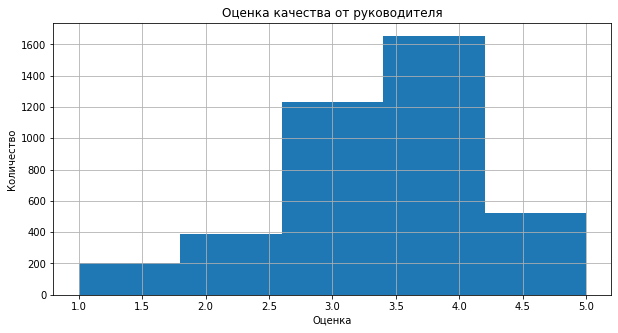

In [70]:
# построим распределение
train_quit['supervisor_evaluation'].hist(bins=5,figsize=(10,5))
plt.title('Оценка качества от руководителя')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show()

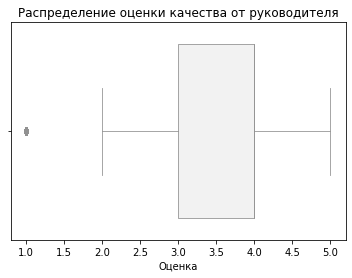

In [71]:
# график распределения внутри годов 
sns.boxplot(
    x=train_quit['supervisor_evaluation'],
    color='0.95', 
    linewidth=0.8
)
plt.title('Распределение оценки качества от руководителя')
plt.xlabel('Оценка')
plt.ylabel('')
plt.show()

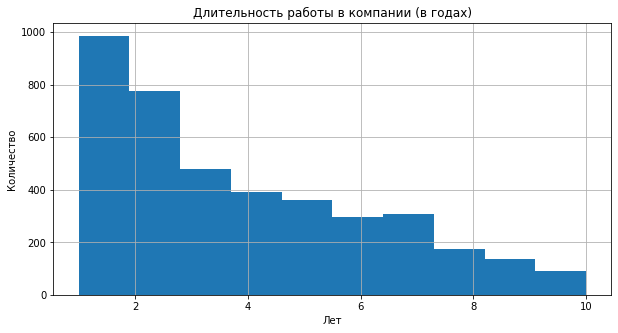

In [72]:
# построим распределение
train_quit['employment_years'].hist(bins=10,figsize=(10,5))
plt.title('Длительность работы в компании (в годах)')
plt.xlabel('Лет')
plt.ylabel('Количество')
plt.show()

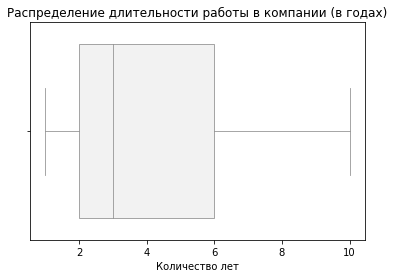

In [73]:
# график распределения внутри годов 
sns.boxplot(
    x=train_quit['employment_years'],
    color='0.95', 
    linewidth=0.8
)
plt.title('Распределение длительности работы в компании (в годах)')
plt.xlabel('Количество лет')
plt.ylabel('')
plt.show()

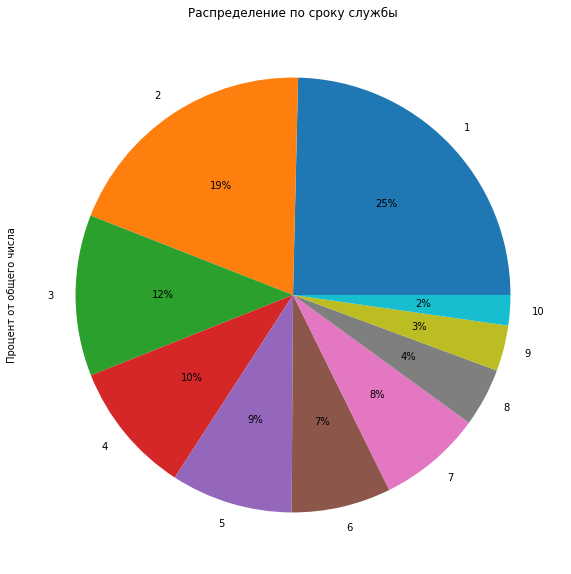

In [102]:
labels = train_quit.pivot_table(index='employment_years', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots(figsize=(10,10))

ax.pie(
    train_quit.pivot_table(
        index='employment_years', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по сроку службы'
)

plt.show()

Большую часть составляют сотрудники от 1-2 лет работы: 44%, при этом четверть занимают сотрудники отработавшие 1 год. Затем от 3-4 лет работы: 22%.

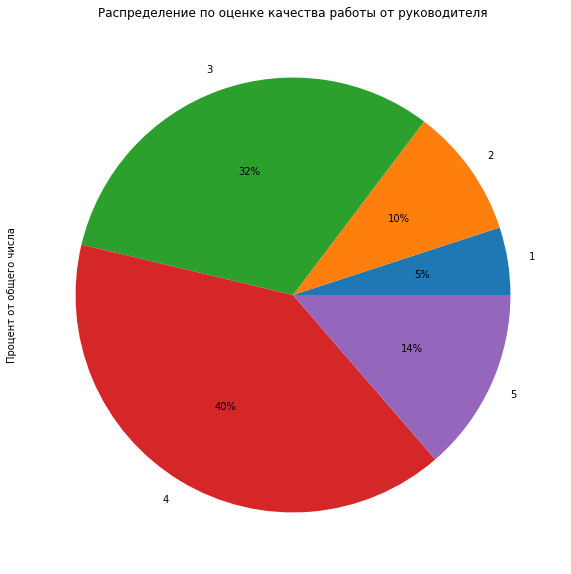

In [90]:
labels = train_job_satisfaction_rate.pivot_table(index='supervisor_evaluation', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots(figsize=(10,10))

ax.pie(
    train_job_satisfaction_rate.pivot_table(
        index='supervisor_evaluation', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по оценке качества работы от руководителя'
)

plt.show()

40% сотрудников имеют оценку 4. 32% сотрудкников имеют оценку 3. Немного не хватило до 15% сотрудникам отличникам, у них 14%. Единиццу послучили 5% сотрудников.

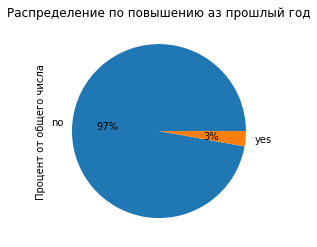

In [77]:
labels = train_quit.pivot_table(index='last_year_promo', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_quit.pivot_table(
        index='last_year_promo', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по повышению аз прошлый год'
)

plt.show()

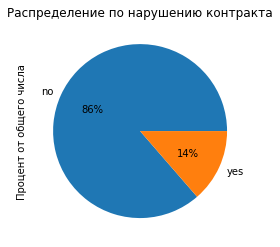

In [78]:
labels = train_quit.pivot_table(index='last_year_violations', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_quit.pivot_table(
        index='last_year_violations', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по нарушению контракта'
)

plt.show()

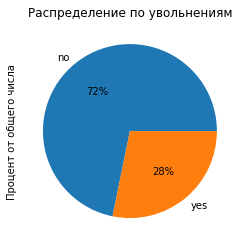

In [79]:
labels = train_quit.pivot_table(index='quit', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_quit.pivot_table(
        index='quit', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по увольнениям'
)

plt.show()

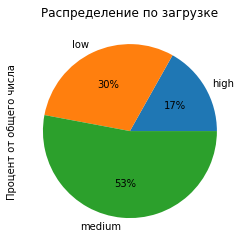

In [80]:
labels = train_quit.pivot_table(index='workload', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_quit.pivot_table(
        index='workload', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по загрузке'
)

plt.show()

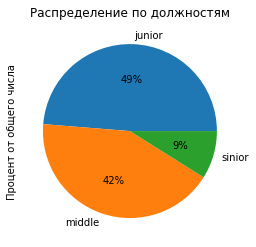

In [81]:
labels = train_quit.pivot_table(index='level', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_quit.pivot_table(
        index='level', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по должностям'
)

plt.show()

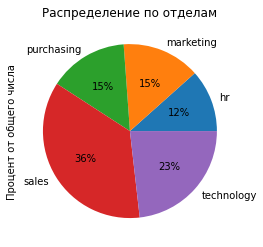

In [82]:
labels = train_quit.pivot_table(index='dept', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_quit.pivot_table(
        index='dept', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по отделам'
)

plt.show()

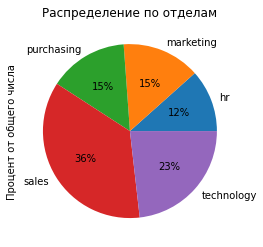

In [83]:
labels = train_quit.pivot_table(index='dept', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_quit.pivot_table(
        index='dept', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по отделам'
)

plt.show()

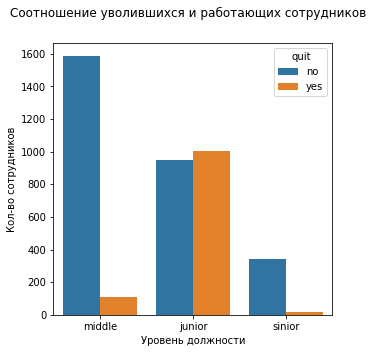

In [84]:
fig, axes = plt.subplots(figsize=(5,5))
plt.suptitle('Соотношение уволившихся и работающих сотрудников')
sns.countplot(x ='level', data = train_quit, hue = 'quit').set(
    xlabel='Уровень должности', ylabel='Кол-во сотрудников'
)
plt.show()

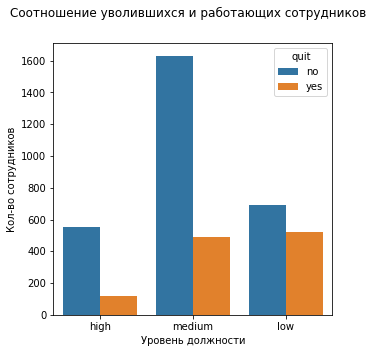

In [85]:
fig, axes = plt.subplots(figsize=(5,5))
plt.suptitle('Соотношение уволившихся и работающих сотрудников')
sns.countplot(x ='workload', data = train_quit, hue = 'quit').set(
    xlabel='Уровень должности', ylabel='Кол-во сотрудников'
)
plt.show()

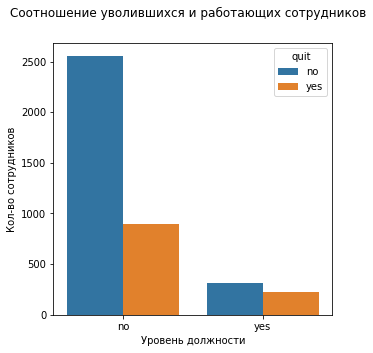

In [86]:
fig, axes = plt.subplots(figsize=(5,5))
plt.suptitle('Соотношение уволившихся и работающих сотрудников')
sns.countplot(x ='last_year_violations', data = train_quit, hue = 'quit').set(
    xlabel='Уровень должности', ylabel='Кол-во сотрудников'
)
plt.show()

Построим распределение относительно уволившихся сотрудников.

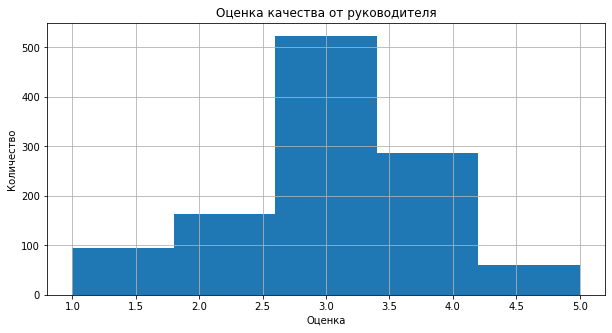

In [87]:
# построим распределение
train_quit[train_quit['quit'] == 'yes']['supervisor_evaluation'].hist(bins=5,figsize=(10,5))
plt.title('Оценка качества от руководителя')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.show()

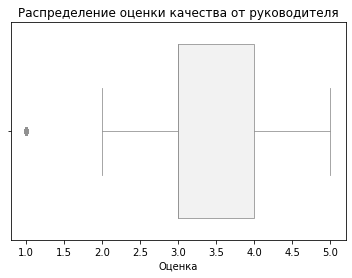

In [88]:
# график распределения внутри годов 
sns.boxplot(
    x=train_quit[train_quit['quit'] == 'yes']['supervisor_evaluation'],
    color='0.95', 
    linewidth=0.8
)
plt.title('Распределение оценки качества от руководителя')
plt.xlabel('Оценка')
plt.ylabel('')
plt.show()

In [91]:
train_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no


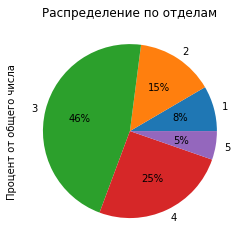

In [92]:
labels = train_quit[train_quit['quit'] == 'yes'].pivot_table(index='supervisor_evaluation', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_quit[train_quit['quit'] == 'yes'].pivot_table(
        index='supervisor_evaluation', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по отделам'
)

plt.show()

Среди уволившихся 46% имели оцценку 3 и 25% имели оценку 4 от руководителя. И лишь 23% имели 2 или 1 оценку.

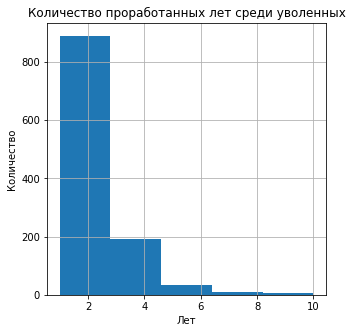

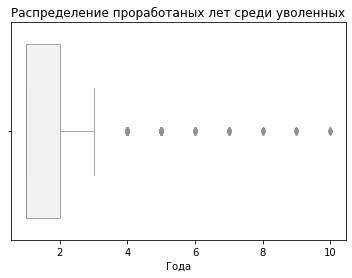

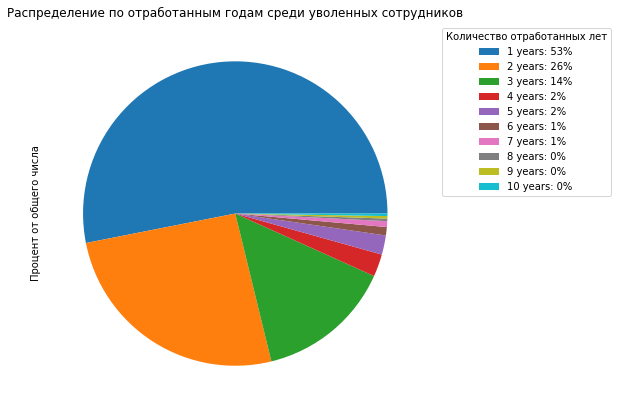

In [124]:
# построим распределение
train_quit[train_quit['quit'] == 'yes']['employment_years'].hist(bins=5,figsize=(5,5))
plt.title('Количество проработанных лет среди уволенных')
plt.xlabel('Лет')
plt.ylabel('Количество')
plt.show()

# график распределения внутри годов 
sns.boxplot(
    x=train_quit[train_quit['quit'] == 'yes']['employment_years'],
    color='0.95', 
    linewidth=0.8
)
plt.title('Распределение проработаных лет среди уволенных')
plt.xlabel('Года')
plt.ylabel('')
plt.show()

# гарфик круга
import matplotlib.pyplot as plt
import pandas as pd

# Пример данных
pivot_data = train_quit[train_quit['quit'] == 'yes'].pivot_table(
    index='employment_years',
    values='id',
    aggfunc='count'
)

percentages = pivot_data['id']/pivot_data['id'].sum()*100
labels = [f"{index} years" for index in pivot_data.index]
fig, ax = plt.subplots(figsize=(7, 7))

wedges, texts, autotexts = ax.pie(pivot_data['id'],autopct='%1.0f%%')

for text in autotexts:
    text.set_color('none')

ax.legend(
    wedges,
    [f"{label}: {percentage:.0f}%" for label, percentage in zip(labels, percentages)],
    title="Количество отработанных лет",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по отработанным годам среди уволенных сотрудников'
)
plt.show()

Больше 50% (53%) уволенных сотрудников покринули компанию в течении года. 26% в течении 2 лет, и 14% в течении 3 лет.

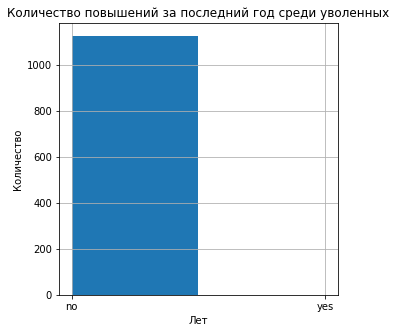

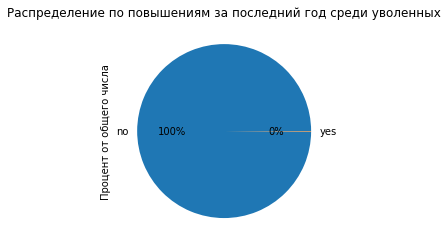

In [100]:
# построим распределение
train_quit[train_quit['quit'] == 'yes']['last_year_promo'].hist(bins=2,figsize=(5,5))
plt.title('Количество повышений за последний год среди уволенных')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

# гарфик круга
labels = train_quit[train_quit['quit'] == 'yes'].pivot_table(index='last_year_promo', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_quit[train_quit['quit'] == 'yes'].pivot_table(
        index='last_year_promo', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по повышениям за последний год среди уволенных'
)

plt.show()


Среди уволенных сотрудников не было повышений за последний год.

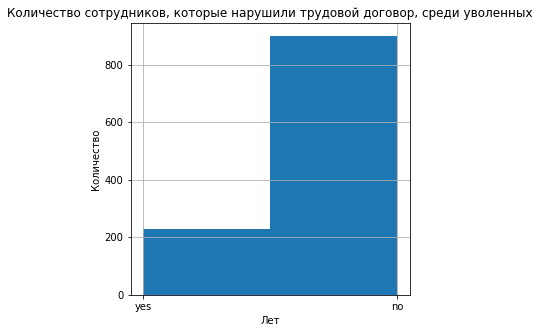

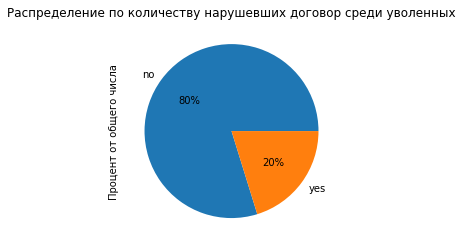

In [104]:
# построим распределение
train_quit[train_quit['quit'] == 'yes']['last_year_violations'].hist(bins=2,figsize=(5,5))
plt.title('Количество сотрудников, которые нарушили трудовой договор, среди уволенных')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()


# гарфик круга
labels = train_quit[train_quit['quit'] == 'yes'].pivot_table(index='last_year_violations', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_quit[train_quit['quit'] == 'yes'].pivot_table(
        index='last_year_violations', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по количеству нарушевших договор среди уволенных'
)

plt.show()


Среди уволенных лишь 20% нарушили договор.

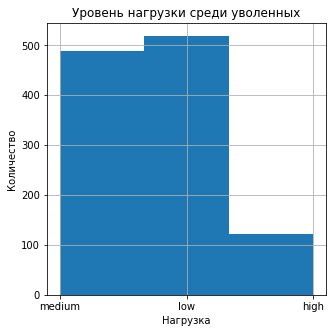

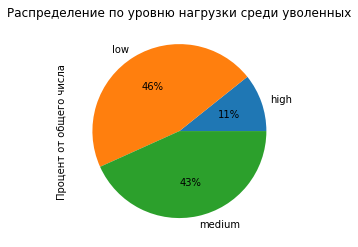

In [112]:
# построим распределение
train_quit[train_quit['quit'] == 'yes']['workload'].hist(bins=3,figsize=(5,5))
plt.title('Уровень нагрузки среди уволенных')
plt.xlabel('Нагрузка')
plt.ylabel('Количество')
plt.show()

# гарфик круга
labels = train_quit[train_quit['quit'] == 'yes'].pivot_table(index='workload', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_quit[train_quit['quit'] == 'yes'].pivot_table(
        index='workload', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по уровню нагрузки среди уволенных'
)

plt.show()


Низкая и средня нагрузка имеют почти равные показатели: 46 и 43.

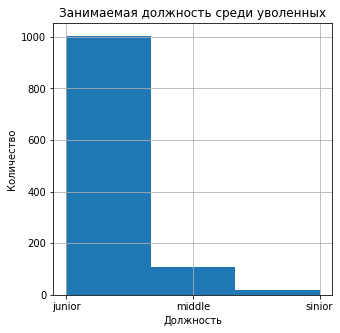

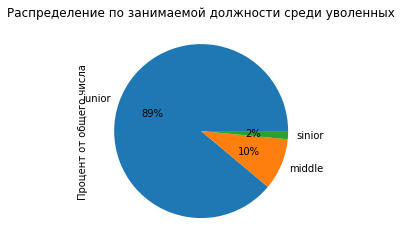

In [111]:
# построим распределение
train_quit[train_quit['quit'] == 'yes']['level'].hist(bins=3,figsize=(5,5))
plt.title('Занимаемая должность среди уволенных')
plt.xlabel('Должность')
plt.ylabel('Количество')
plt.show()

# гарфик круга
labels = train_quit[train_quit['quit'] == 'yes'].pivot_table(index='level', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_quit[train_quit['quit'] == 'yes'].pivot_table(
        index='level', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по занимаемой должности среди уволенных'
)

plt.show()


Подавляющие большенство (89%) уволенных были junior.

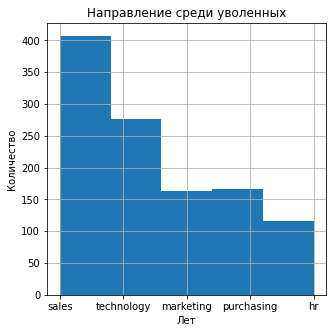

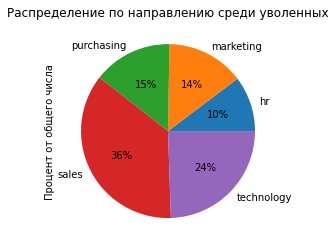

In [115]:
# построим распределение
train_quit[train_quit['quit'] == 'yes']['dept'].hist(bins=5,figsize=(5,5))
plt.title('Направление среди уволенных')
plt.xlabel('Лет')
plt.ylabel('Количество')
plt.show()

# гарфик круга
labels = train_quit[train_quit['quit'] == 'yes'].pivot_table(index='dept', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_quit[train_quit['quit'] == 'yes'].pivot_table(
        index='dept', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по направлению среди уволенных'
)

plt.show()


Среди уволенных разбиение по отделам более мнее равномерное. Есть лидер sales (36%), как ожидаемо, в отделе продаж текучка. 24% отдел technology. ОСтальные разбиты от 15 до 10%.

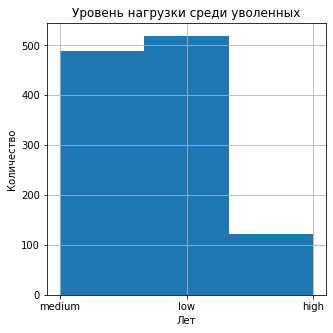

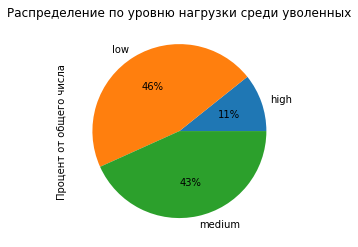

In [108]:
# построим распределение
train_quit[train_quit['quit'] == 'yes']['workload'].hist(bins=3,figsize=(5,5))
plt.title('Уровень нагрузки среди уволенных')
plt.xlabel('Лет')
plt.ylabel('Количество')
plt.show()

# гарфик круга
labels = train_quit[train_quit['quit'] == 'yes'].pivot_table(index='workload', values='id', aggfunc='count').index.unique()
fig, ax = plt.subplots()

ax.pie(
    train_quit[train_quit['quit'] == 'yes'].pivot_table(
        index='workload', 
        values='id', 
        aggfunc='count'
    )['id'], 
    autopct='%1.0f%%', 
    labels=labels
)
ax.set(
    ylabel='Процент от общего числа',
    title='Распределение по уровню нагрузки среди уволенных'
)

plt.show()


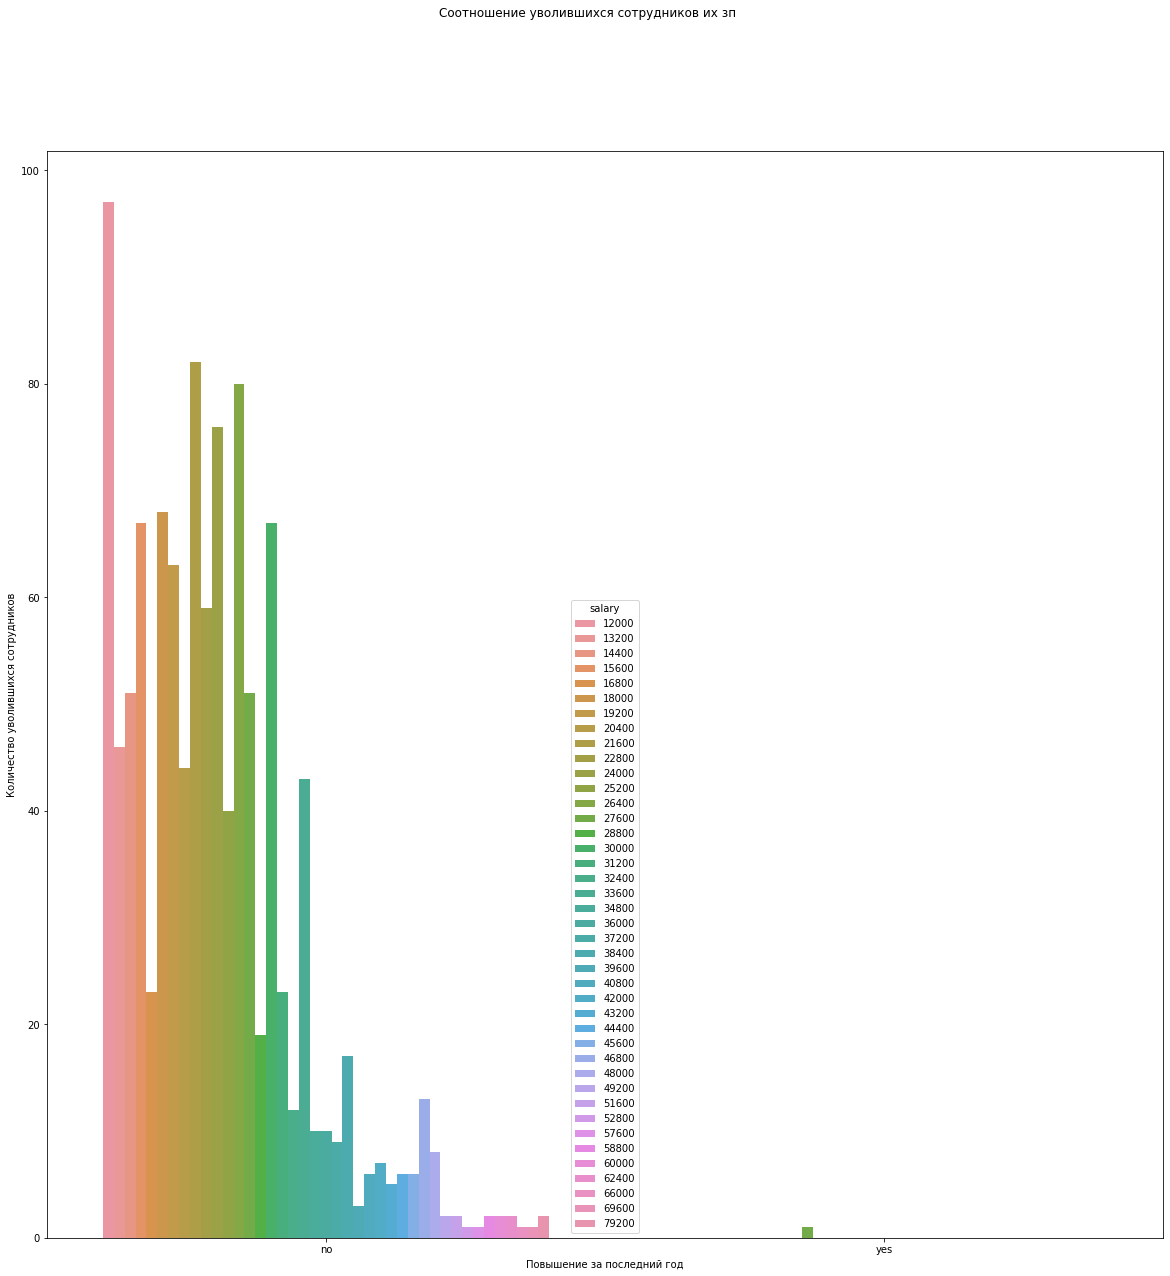

In [115]:
fig, axes = plt.subplots(figsize=(20,20))
plt.suptitle('Соотношение уволившихся сотрудников их зп')
sns.countplot(x='last_year_promo', data=train_quit[train_quit['quit'] == 'yes'], hue='salary').set(
    xlabel='Повышение за последний год', 
    ylabel='Количество уволившихся сотрудников'
)
plt.show()

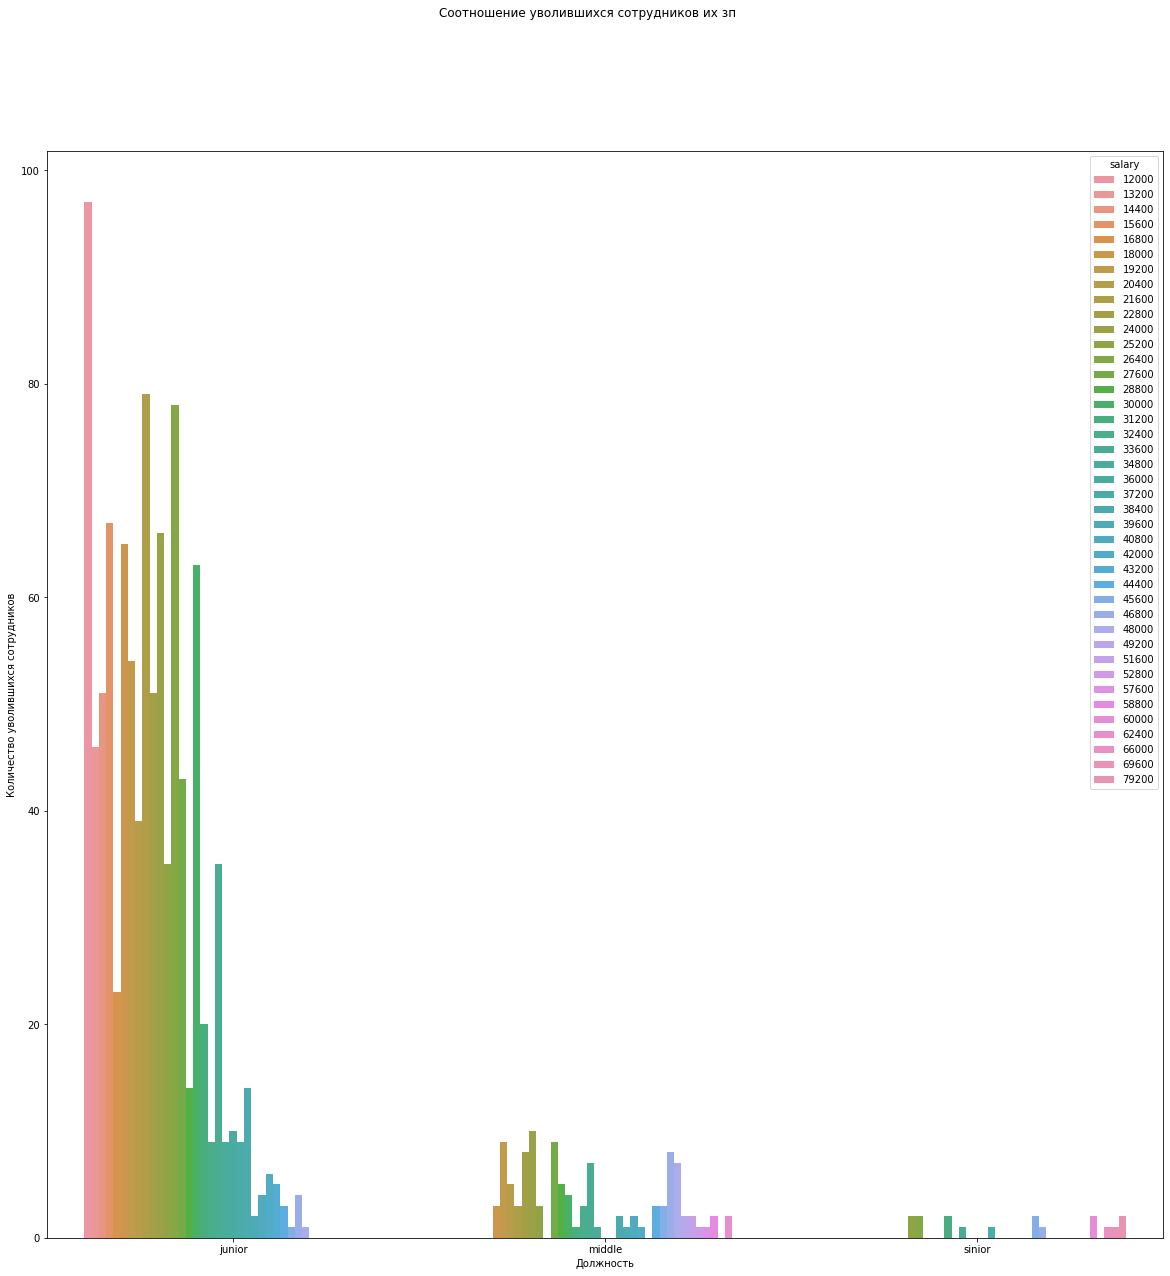

In [114]:
fig, axes = plt.subplots(figsize=(20,20))
plt.suptitle('Соотношение уволившихся сотрудников их зп')
sns.countplot(x='level', data=train_quit[train_quit['quit'] == 'yes'], hue='salary').set(
    xlabel='Должность', 
    ylabel='Количество уволившихся сотрудников'
)
plt.show()

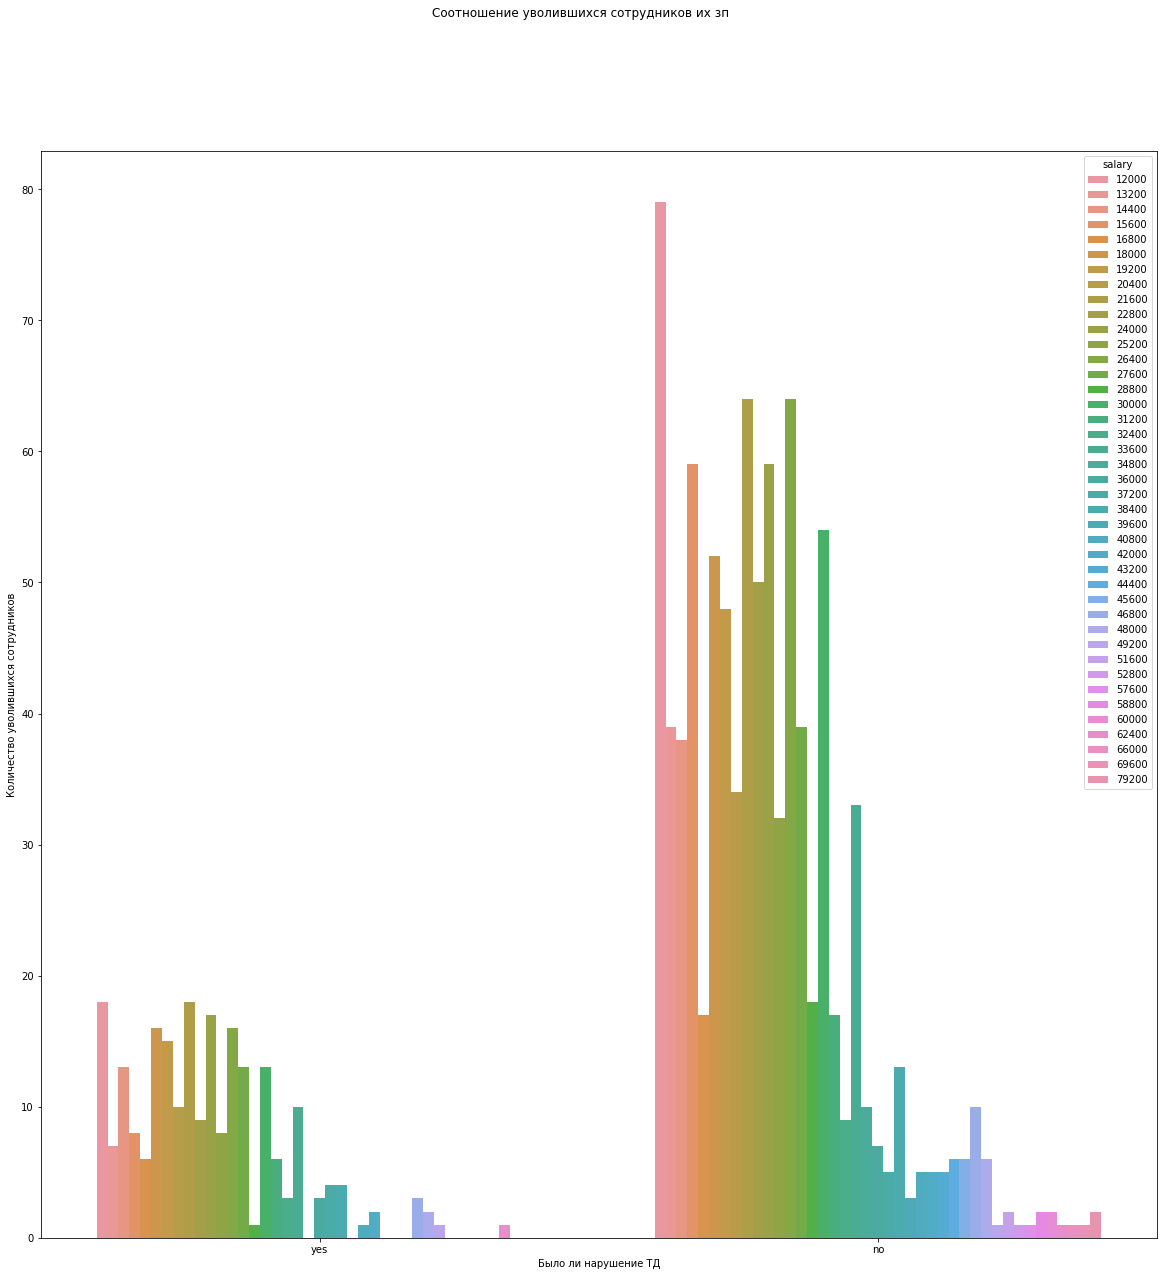

In [113]:
fig, axes = plt.subplots(figsize=(20,20))
plt.suptitle('Соотношение уволившихся сотрудников их зп')
sns.countplot(x='last_year_violations', data=train_quit[train_quit['quit'] == 'yes'], hue='salary').set(
    xlabel='Было ли нарушение ТД', 
    ylabel='Количество уволившихся сотрудников'
)
plt.show()

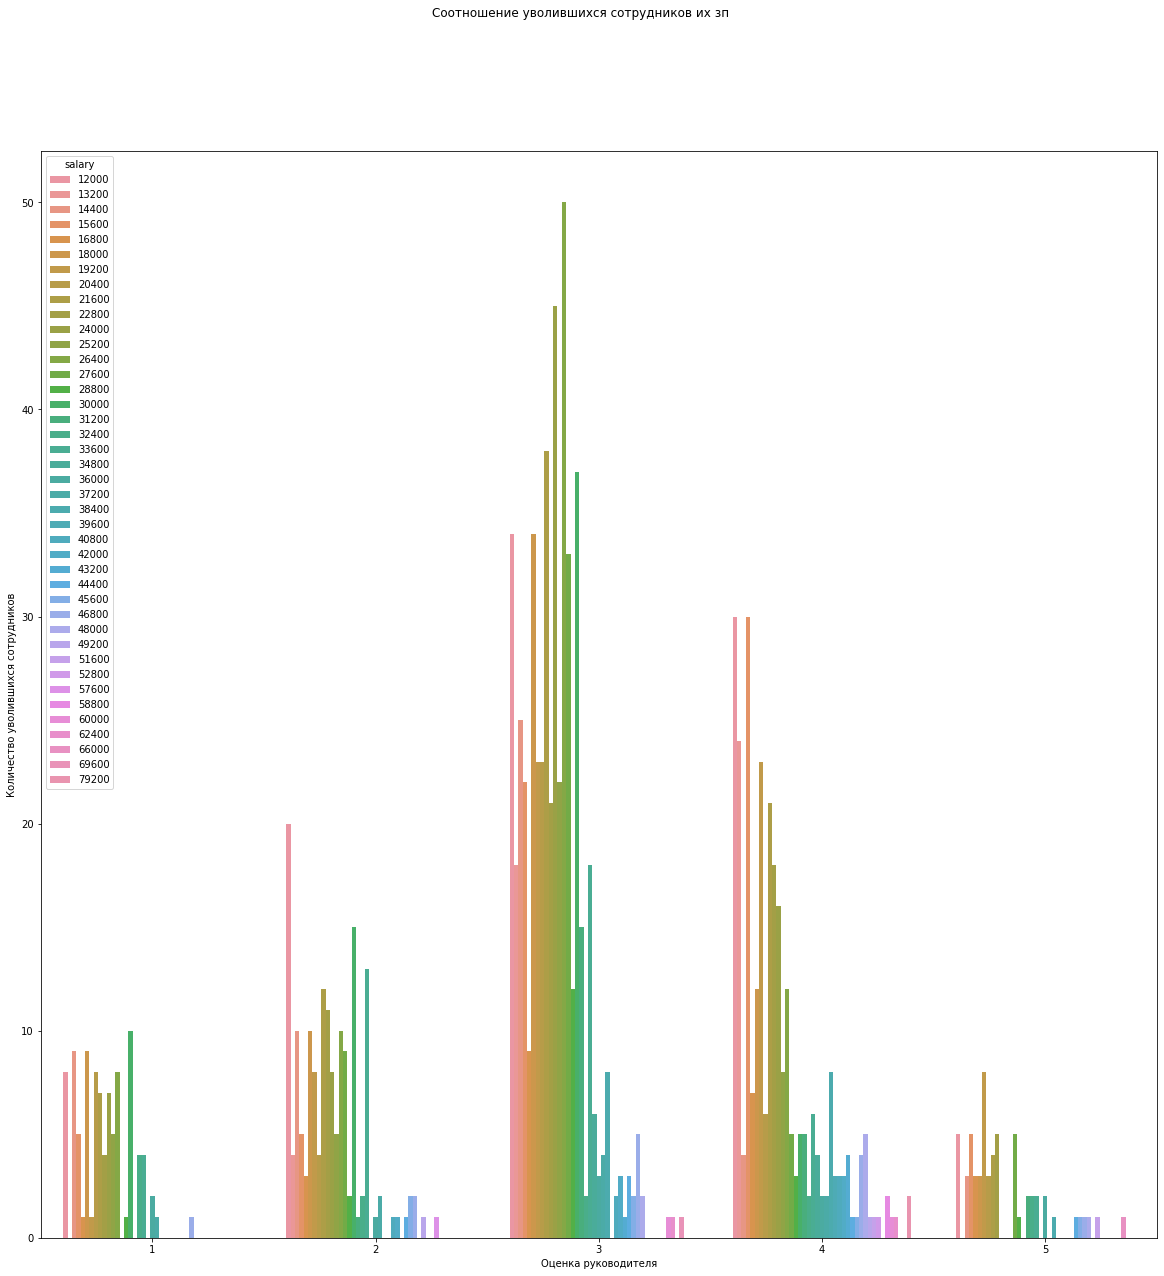

In [110]:
fig, axes = plt.subplots(figsize=(20,20))
plt.suptitle('Соотношение уволившихся сотрудников их зп')
sns.countplot(x='supervisor_evaluation', data=train_quit[train_quit['quit'] == 'yes'], hue='salary').set(
    xlabel='Оценка руководителя', 
    ylabel='Количество уволившихся сотрудников'
)
plt.show()

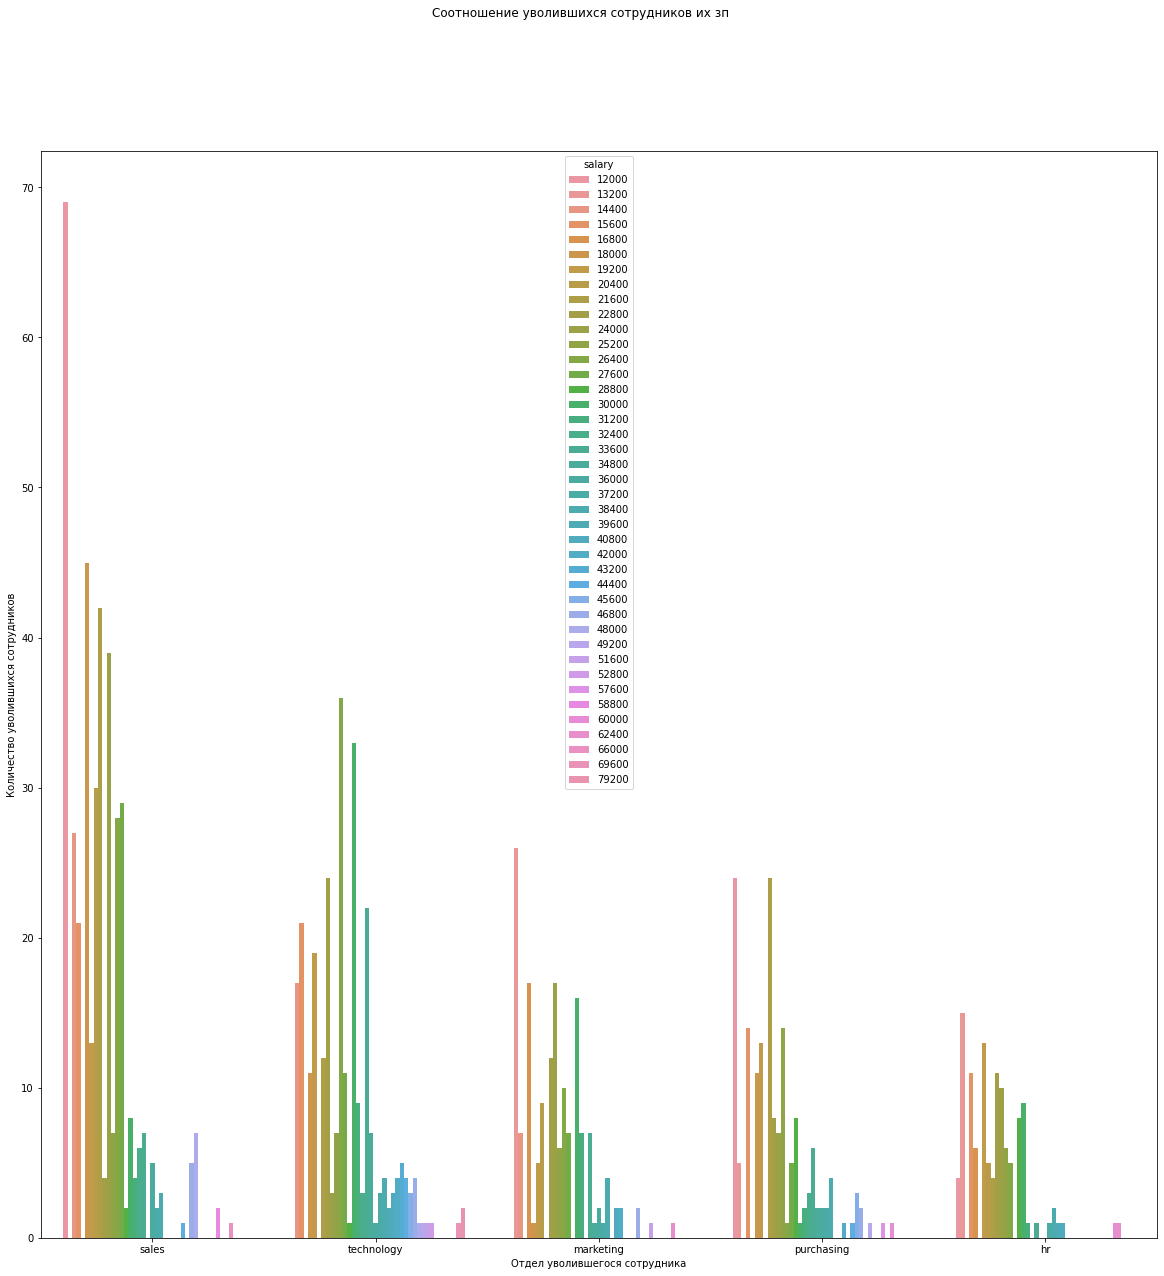

In [112]:
fig, axes = plt.subplots(figsize=(20,20))
plt.suptitle('Соотношение уволившихся сотрудников их зп')
sns.countplot(x='dept', data=train_quit[train_quit['quit'] == 'yes'], hue='salary').set(
    xlabel='Отдел уволившегося сотрудника', 
    ylabel='Количество уволившихся сотрудников'
)
plt.show()

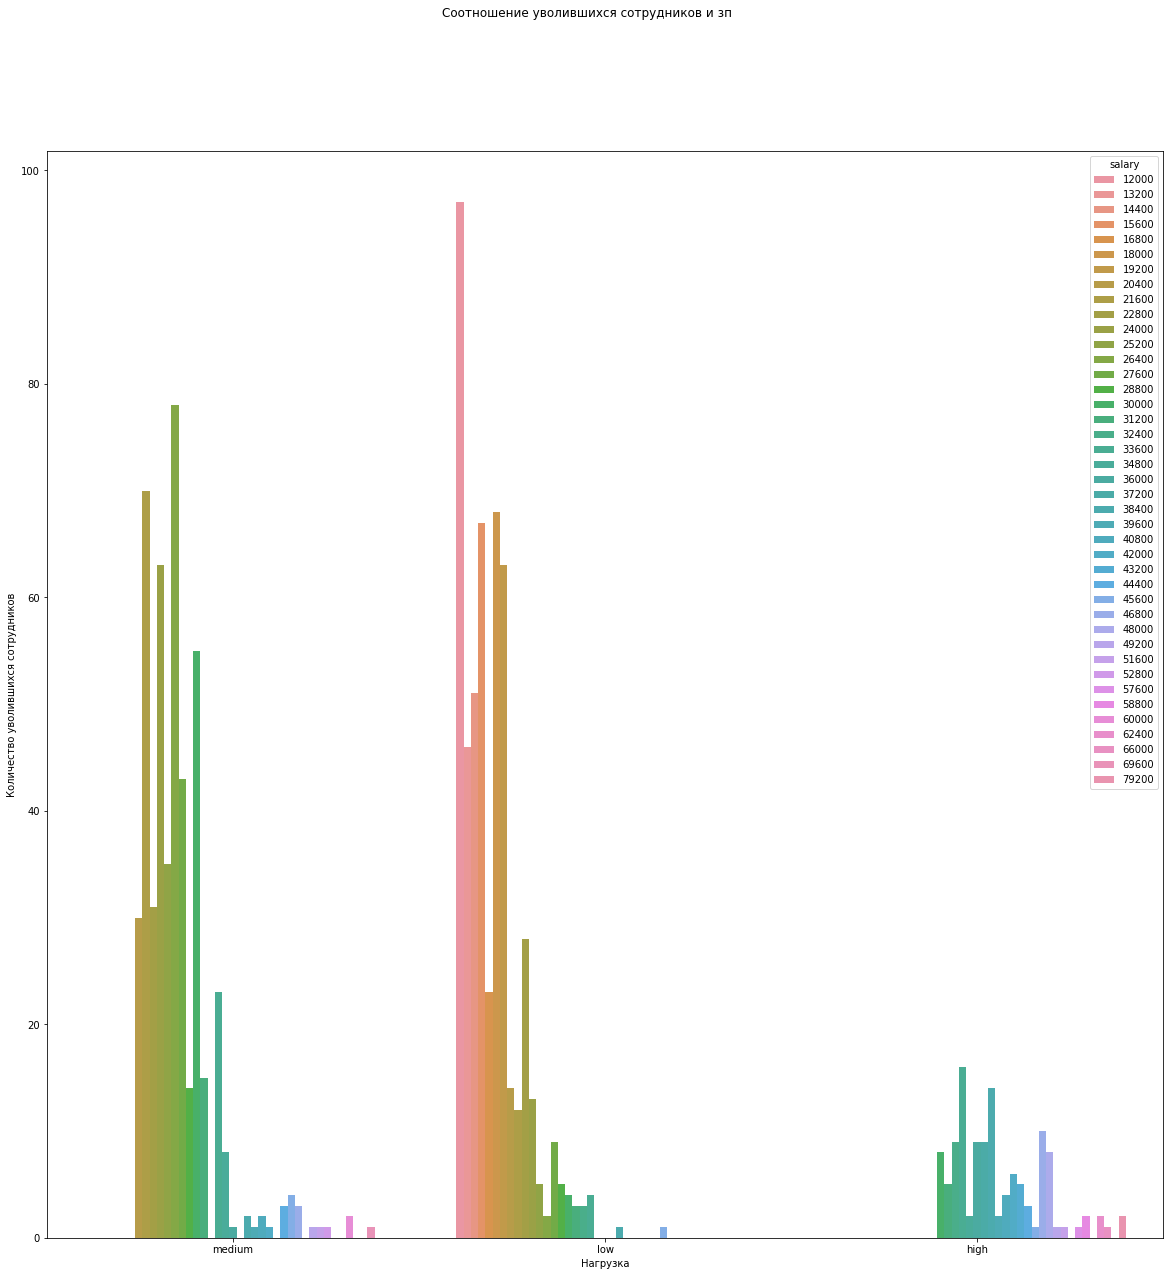

In [107]:
fig, axes = plt.subplots(figsize=(20,20))
plt.suptitle('Соотношение уволившихся сотрудников их зп')
sns.countplot(x='workload', data=train_quit[train_quit['quit'] == 'yes'], hue='salary').set(
    xlabel='Нагрузка', 
    ylabel='Количество уволившихся сотрудников'
)
plt.show()

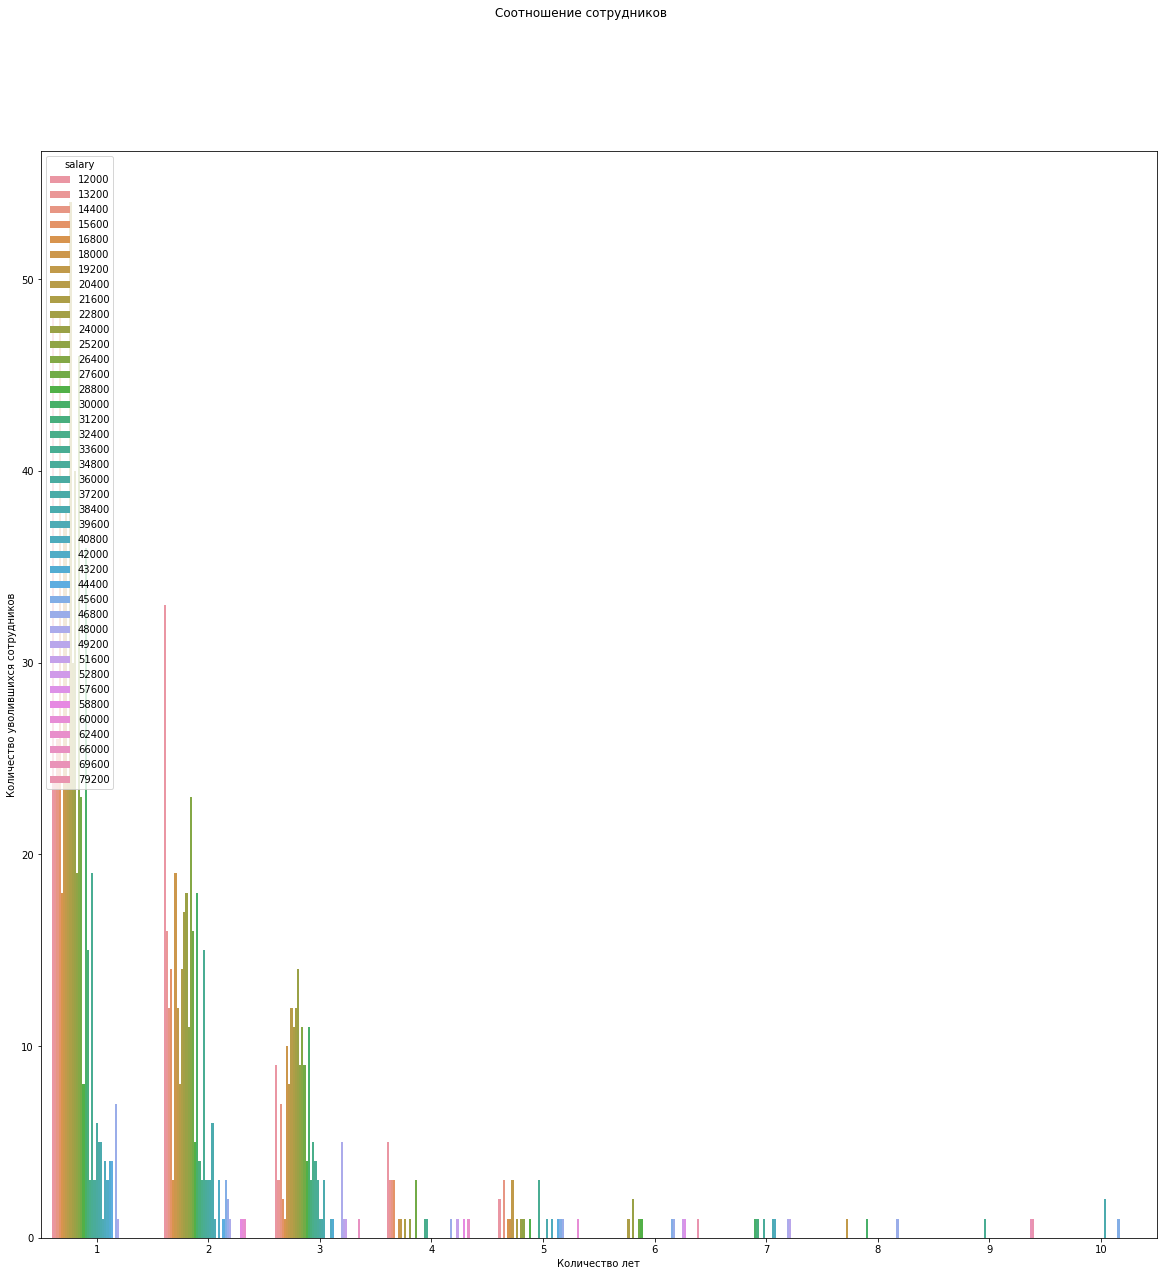

In [105]:
fig, axes = plt.subplots(figsize=(20,20))
plt.suptitle('Соотношение уволившихся сотрудников')
sns.countplot(x='employment_years', data=train_quit[train_quit['quit'] == 'yes'], hue='salary').set(
    xlabel='Количество лет', 
    ylabel='Количество уволившихся сотрудников'
)
plt.show()

In [116]:
dt_2 = train_quit.iloc[:,1:]

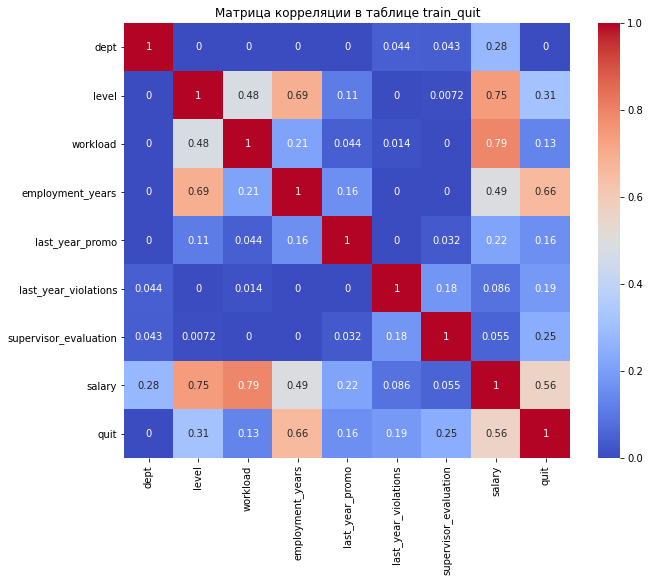

In [119]:
# Вычисление матрицу корреляции с использованием phik
plt.figure(figsize=(10, 8))
sns.heatmap(
    dt_2.phik_matrix(
        interval_cols=[
            'salary',
            'job_satisfaction_rate'
        ]
    ), 
    annot=True,
    cmap='coolwarm'
)
plt.title('Матрица корреляции в таблице train_quit')
plt.show()

##### Вывод  шага 3.1.

Очень высоких корреляций (0.9 +) не видно, мультиколлинеарности нет.<br>
Сильная корреляция наблюдается в связи с Уровенем загруженности сотрудника и Зарплатой (0,79), Количество лет проработанных и уровень занимаемой должности (0,69), и Уровень занимаемой должности и Зарплата (0,75).<br>
Остальные значения имеют низкую корреляцию. 

#### Составьте портрет «уволившегося сотрудника».

<i>Составьте портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

##### Вывод  шага 3.2.

Уволенных сотрудников почти треть от общего количества. В тренировочной и тестовой выборках число уволенных сотрудников примерно одинаковое.
Анализируя графики, видно, что больше всего увольняются сотрудники с уровнем должности junior, с уровнем загруженности работой low. 
Таким образом, типичный уволенный сотрудник: 
<br>недавно работающий не загруженный работой junior
<br>не очень ценится руководитель
<br>низкая зарплатная плата
<br>проработал до 2 лет

#### Проверьте утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

<i>Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

In [120]:
# объеденяем таблицы по id
df_2 = y_test.merge(test_target_quit, on='id')

In [121]:
# убираем столбец
df_2 = df_2.set_index('id')

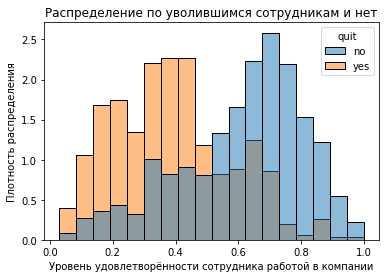

In [122]:
sns.histplot(data=df_2, x='job_satisfaction_rate', hue='quit', stat='density', common_norm=False)
plt.title('Распределение по уволившимся сотрудникам и нет')
plt.xlabel('Уровень удовлетворённости сотрудника работой в компании')
plt.ylabel('Плотность распределения')
plt.show()

##### Вывод  шага 3.3.

Удовлетворенность работой сильно влияет на целевой признак, а значит до обучения моделей нам нужно будет добавить этот признак в тренировочную и тестовую выборки.

### Добавление нового входного признака.

<i> Допустим, job_satisfaction_rate и quit действительно связаны и вы получили необходимое значение метрики в первой задаче. Тогда добавьте job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [123]:
test_features['job_satisfaction_rate_pred'] = grid_search_LR.best_estimator_.predict(X_test_1)
test_features.head()

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.863333
1,686555,hr,junior,medium,1,no,no,4,30000,0.668537
2,467458,sales,middle,low,5,no,no,4,19200,0.654000
3,418655,sales,middle,low,6,no,no,4,19200,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,0.824643


In [124]:
train_quit['job_satisfaction_rate_pred'] = grid_search_LR.best_estimator_.predict(train_quit.drop(['quit','id'], axis=1))
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.658235
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.848000
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.364091
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.791667


#### Вывод четвертого шага.

Новый входной признак в тестовую и тренировочную выборки добавлен и готов к подготовке данных для обучения моделей.

### Подготовка данных.

<i>Подготовьте признаки так же, как и в первой задаче: выполните подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

In [125]:
X_train_2 = train_quit.drop(['quit','id'], axis=1)
y_train_2 = train_quit['quit']
X_train_2.shape

(4000, 9)

In [126]:
dt_test_2 = test_features.merge(test_target_quit, on='id')

In [127]:
X_test_2 = dt_test_2.drop(['quit','id'], axis=1)
y_test_2 = dt_test_2['quit']
X_test_2.shape

(2000, 9)

In [128]:
# Кодируем мотодом LabelEncoder, потому что целевой признак теперь категориальный.
label_encoder = LabelEncoder()
y_train_2 = label_encoder.fit_transform(y_train_2)
y_test_2 = label_encoder.transform(y_test_2)

In [129]:
ohe_columns = [
    'last_year_violations', 
    'last_year_promo', 
    'dept'
]
ord_columns = [
    'level', 
    'workload' 
]
num_columns = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate_pred'] 

In [130]:
# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE + SimpleImputer
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior','middle','sinior'],
                    ['low','medium','high']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [131]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            
        ),
        (
            'ohe',
            OneHotEncoder(handle_unknown='ignore')
        )
    ]
)

In [132]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ord_pipe,ord_columns),
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(),num_columns)
    ],
    remainder='passthrough'
)

In [133]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_2 = Pipeline(
    [
        ('preprocessor',data_preprocessor),
        ('models', model_lr)
    ]
)

In [134]:
param_grid = [
  {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [SVC(random_state=RANDOM_STATE,kernel = 'rbf',probability=True)],
        'models__C': [0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    }
]

#### Вывод пятого шага.

Данные для обучения модели готовы, параметры собраны.

### Обучение модели. 

<i>Обучите как минимум три модели. Как минимум для двух из них подберите гиперпараметры. Проверьте качество лучшей модели.
Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC 
≥
0.91
≥0.91 на тестовой выборке. Напомним: отбор признаков часто помогает улучшить метрику.

In [135]:
# используем метод RandomizedSearchCV для запуска обучения перебором
randomized_search = RandomizedSearchCV(
    pipe_final_2, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [136]:
randomized_search.fit(X_train_2, y_train_2)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(categories=[['junior',
                                                                                                                            'middle',
                                                                                                                            'sinior'],
                                                                                                                           ['low',
                                                                                                                            'medium',
                                                                                                                            'high']],
                                                                                                               handle_unknown='use_encoded_value',
                                                                                                               unknown_value...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': [0.1, 1, 10, 100],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [137]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                 

In [138]:
pd.DataFrame(randomized_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,param_models__C,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.028656,0.001282,0.013316,0.000335,MinMaxScaler(),11.0,10.0,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.883741,0.908364,0.875562,0.878413,0.894403,0.888097,0.012003,13
1,0.024353,0.000447,0.012614,0.000688,StandardScaler(),10.0,3.0,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.896962,0.900418,0.902682,0.898350,0.919755,0.903633,0.008290,7
2,0.027934,0.000911,0.012654,0.000546,StandardScaler(),13.0,11.0,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.885168,0.887789,0.875974,0.852632,0.899476,0.880208,0.015695,19
3,0.025831,0.000399,0.013126,0.000165,StandardScaler(),2.0,9.0,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.906008,0.910536,0.878131,0.898602,0.886064,0.895868,0.012134,11
4,0.024986,0.001154,0.012772,0.000681,StandardScaler(),4.0,4.0,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.901131,0.898154,0.897930,0.901475,0.917488,0.903235,0.007275,8
5,0.028125,0.000120,0.012890,0.000290,MinMaxScaler(),12.0,14.0,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.877517,0.903345,0.870787,0.861625,0.898038,0.882262,0.015959,17
6,0.023976,0.000607,0.012679,0.000164,MinMaxScaler(),9.0,2.0,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.882607,0.863469,0.861208,0.873361,0.889133,0.873956,0.010752,20
7,0.025308,0.000581,0.013227,0.000184,MinMaxScaler(),4.0,4.0,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.901131,0.898154,0.897930,0.901475,0.917488,0.903235,0.007275,8
8,0.027367,0.000307,0.013246,0.000244,StandardScaler(),7.0,7.0,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.903139,0.932200,0.898108,0.917136,0.926909,0.915498,0.013168,3
9,0.028170,0.001143,0.013333,0.000403,StandardScaler(),6.0,13.0,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.894705,0.881611,0.883408,0.878436,0.902859,0.888204,0.009153,12


Лучшей моделью оказалась построенная методом опорных векторов со степенью регуляризации 10.

In [140]:
y_test_proba = randomized_search.predict_proba(X_test_2)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_2, y_test_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.9252485479760564


#### Вывод шестого шага.

Результат метрики получился 0.925, то есть практически такой же, как на тренировочной выборке.

### Шаг. Общий вывод

Мы завершили работу над второй задачей и обучили модель предсказывать, уволится сотрудник из компании или нет. Лучшей моделью для этой задачи оказался метод опорных векторов (точность предсказаний около 92.5%).

### Общий вывод.

<i>Сформулируйте общий вывод:
опишите задачу;
<br>опишите все этапы работы;
<br>добавьте выводы и дополнительные предложения для бизнеса.

Была разработана модель по уменьшению оттока сотрудников компании. 
Была поставлена задача сначала: построить модель, которая может предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

На пути к выполнению этой задачи мы провели следующую работу:
В процессе загрузки данных мы получили общую информацию, по которой выяснили, что в обучающей выборке содержится 400 строк. Обнаружены пропуски в колонках, связанных с отделом и занимаемой должностью, однако дубликатов нет, и форматы данных соответствуют ожиданиям. В тестовой выборке с входными данными имеется 2000 строк, также с пропусками в колонках отдела и занимаемой должности, без дубликатов, и все форматы данных корректны. В тестовом наборе с целевым признаком также 2000 строк, дубликатов и пропусков нет, и форматы данных соответствуют требованиям.

На этапе предобработки данных мы проверили категориальные признаки на наличие ошибок. Проанализировали количественные данные на достоверность и убедились в отсутствии отрицательных и аномальных значений.

В ходе исследовательского анализа данных оценили распределение данных во всех таблицах. По итогам анализа данные выглядят достоверно, выбросы отсутствуют, а корреляционный анализ не выявил утечки целевого признака.

При подготовке данных мы осуществили кодирование, масштабирование и обработку пропусков с использованием пайплайнов. Поскольку целевой признак является непрерывным числовым значением, для обучения выбрали две модели регрессии: линейную регрессию и дерево (в последнем случае использовали поиск по гиперпараметрам). Обучили модели и отобрали лучшую на основе метрики SMAPE. Как оказалось, модель решающего дерева с максимальной глубиной 14 и числом признаков для поиска лучшего разбиения тоже равным 13 показала лучшие результаты. Проверка на тестовом наборе показала, что значение метрики изменилось в лучшую сторону, но не сильно. Значение метрики SMAPE равна: 14.11.

После чего выполнили вторую задачу: построили модель, которая может предсказать, уволится сотрудник из компании или нет.

После загрузки новых данных провели анализ, который показал отсутствие пропусков и дубликатов. Обучающая выборка по-прежнему содержит 4000 строк, а тестовая — 2000.

В процессе предобработки данных была проверена новая колонка "quit" в обеих выборках, и ошибок обнаружено не было. Распределение этих данных аналогично предыдущему исследованию.

Во время исследовательского анализа данных изучили распределение нового признака "Увольнение" и составили портрет "типичного" увольняющегося сотрудника: это недавно нанятый сотрудник с невысокой загрузкой, на позиции junior, оценённый руководителем не слишком высоко. Также была выявлена сильная корреляция между удовлетворённостью работой и увольнением. Новый признак "удовлетворённость работой" был добавлен как в тестовую, так и в обучающую выборки.
Мы протестировали несколько моделей: логистическую регрессию, метод опорных векторов, KNN и дерево решений, применяя перебор гиперпараметров. По метрике ROC_AUC лучшей моделью оказался метод опорных векторов со сзначеним 10, показавшее точность около 92.5%.

В качестве рекомендации можно предложить повышать удовлетворённость работой среди сотрудников junior: ускорять перевод на позицию medium и увеличивать загрузку, чтобы давать рост сотруднику. 